# Training and Modeling

## Contents<a id='Contents'></a>
* [1 Introduction](#1_Introduction)
* [2 Imports](#2_Imports)
* [3 Load data](#3_Load_data)
    * [3.1 Generate dependent and independent variables](#3.1_Generate_dependent_and_independent_variables)
    * [3.2 Generate balanced data](#3.2_Generate_balanced_data)
* [4 Create functions](#4_Create_functions)
* [5 Training and testing data](#5_Training_and_testing_data)
* [6 Machine learning models](#6_Machine_learning_models)
    * [6.1 Decision Tree](#6.1_Decision_Tree)
    * [6.2 Ensemble Methods - Random Forest](#6.2_Ensemble_Methods_Random_Forest)
    * [6.3 Ensemble Methods - AdaBoost](#6.3_Ensemble_Methods_AdaBoost)
    * [6.4 Logistic Regression](#6.4_Logistic_Regression)
    * [6.5 K-Nearest Neighbors](#6.5_K-Nearest_Neighbors)
    * [6.6 Support Vector Machine](#6.6_Support_Vector_Machine)
* [7 Summary](#7_Summary)

## 1 Introduction<a id='1_Introduction'></a>

This part of the data science project involves training different machine learning models to predict whether a small business will default on its loan. This helps the U.S. SBA and the banks in making informed decisions about whether to grant a loan to a small business or not.

As mentioned previously, this data science project addresses the following questions:
* How can machine learning help in making decisions about whether a loan should be approved or denied by the U.S. SBA? 
* How do the different machine learning algorithms compare in terms of predictive ability, model complexity and computational intensity?
* What are the important data features that affect a model's performance?
* If necessary, what other data should be collected to improve a model's performance and help in accurate decision making?

Criteria for an optimal machine learning model: a simple model that makes accurate predictions of whether a small business shall default its loan or not; is fast to train and make predictions; and is robust to new data.

## 2 Imports<a id='2_Imports'></a>

In [1]:
# Import required libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import pickle

## 3 Load data<a id='3_Load_data'></a>

In [2]:
# Load data for training and modeling
dfCA = pd.read_csv('../data_models/SBAnational_CA_features.csv')
dfCA.head().T

,0,1,2,3,4
LoanNr_ChkDgt,1000506000,1000685001,1000715008,1000746002,1000754002
Name,WEYLAND CORPORATION,ANYWHERE SPORTS PRODUCTIONS,John Dailey,ANGEL,"MCCRANEY, INC."
ApprovalDate,7-Feb-06,25-Mar-97,26-Mar-97,7-Feb-06,28-Feb-97
ApprovalFY,2006,1997,1997,2006,1997
Term,83,84,84,36,300
NoEmp,18,6,2,20,50
NewExist,2,1,1,2,1
CreateJob,5,0,0,20,0
RetainedJob,23,0,0,20,0
UrbanRural,1,0,0,1,0


In [3]:
# Check size of data
dfCA.shape

(130367, 26)

A heat map is a powerful data visualization technique that can be used to visualize correlations/relationships between features in a dataset. As shown below, plotting a heat map (of correlations between the features) of the given dataset reveals strong positive correlations between the features "Default" and "ChgOffPrinGr_log", and the features "DG_log", "GrAppv_log", and "SBA_Appv_log". This makes sense because the former features are correlated in the sense that if a loan is defaulted there is a corresponding charged-off amount. The latter three features are correlated in the sense that they all account for the loan approved/disbursed to a small business (DG_log: log(amount disbursed), GrAppv_log: log(gross amount of loan approved by bank), SBA_Appv_log: log(SBA’s guaranteed amount of approved loan)).

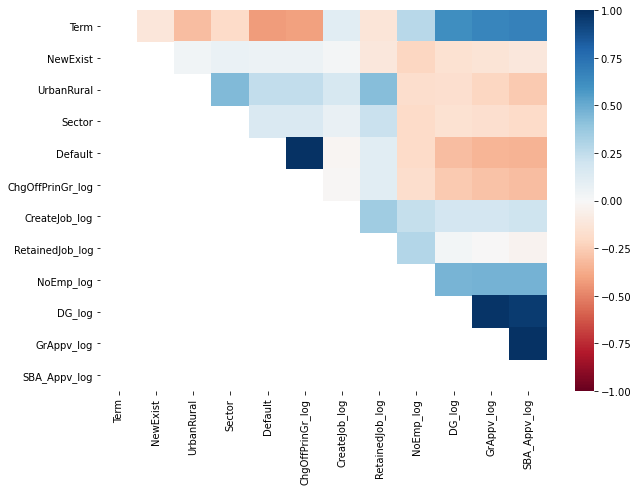

In [4]:
# Heatmap of correlations in the data
plt.rcParams['figure.figsize']=[10,7]
drop_col_list = ['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob',
                 'Term_log', 'DisbursementGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
mask = np.tril(dfCA.drop(drop_col_list, axis=1).corr())
sns.heatmap(dfCA.drop(drop_col_list, axis=1).corr(), vmin=-1, vmax=1, center=0, 
            cmap='RdBu', mask=mask);

If there are strong positive (or negative) correlations between the features of a dataset, then the performance of a model will be highly likely impacted by the problem of "multicollinearity". Multicollinearity occurs when an independent variable (or feature) is highly correlated with one or more of the other independent variables in a multiple regression equation, i.e., if one independent variable can be linearly predicted from the others with a high degree of accuracy. This is a problem because it undermines the statistical significance of an independent variable, and hence can lead to skewed or misleading results.

While some algorithms are immune to multicollinearity, like decision trees and boosted trees, others are not, for example, logistic regression and linear regression, etc. Therefore it is important to fix the problem of multicollinearity before training machine learning models. One of the easiest way to deal with this problem is to delete or eliminate one (or more) of the strongly correlated features. For the given dataset, removing the strongly correlated features "ChgOffPrinGr_log", "DG_log" and "GrAppv_log" results in a heat map plotted below. This plot reveals the final list of features that will be used for training machine learning models.

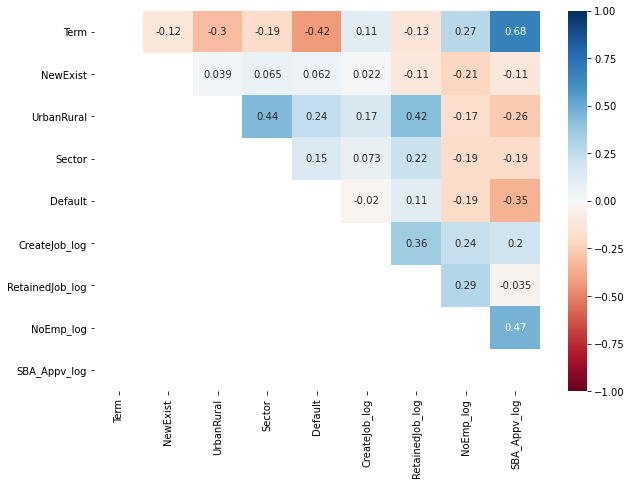

In [5]:
# Remove high-correlation features that are not target variables
drop_col_list = drop_col_list + ['ChgOffPrinGr_log', 'DG_log', 'GrAppv_log']
mask = np.tril(dfCA.drop(drop_col_list, axis=1).corr())
sns.heatmap(dfCA.drop(drop_col_list, axis=1).corr(), annot=True, vmin=-1, vmax=1,
            center=0, cmap='RdBu', mask=mask);

### 3.1 Generate dependent and independent variables<a id='3.1_Generate_dependent_and_independent_variables'></a>

In [6]:
# Split data into dependent (y) and independent variables (X)
features_list = ['Term', 'NewExist', 'UrbanRural', 'Sector', 'CreateJob_log', 
                 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log']
X = dfCA[features_list]
X.head()

,Term,NewExist,UrbanRural,Sector,CreateJob_log,RetainedJob_log,NoEmp_log,SBA_Appv_log
0,83,2,1,61,0.778151,1.380211,1.278754,4.698979
1,84,1,0,0,0.000000,0.000000,0.845098,4.096945
2,84,1,0,0,0.000000,0.000000,0.477121,3.875119
3,36,2,1,31,1.322219,1.322219,1.322219,4.243063
4,300,1,0,0,0.000000,0.000000,1.707570,5.747218


In [7]:
# Dependent (or target) variable
y = dfCA['Default']
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: Default, dtype: int64


In [8]:
# Check count for non-default (0) and default (1) values
y.value_counts()

0    105570
1     24797
Name: Default, dtype: int64

The dataset is imbalanced with the instances for the number of loans paid in full about 4-times the instances for the defaulted loans. For optimal prediction results that are not biased towards any class, it is important to treat the imbalance in a dataset as discussed below.

### 3.2 Generate balanced data<a id='3.2_Generate_balanced_data'></a>

There are a number of ways to treat imbalance in a dataset:
* Collect more data is possible.
* Generate syntehtic data using algorithms like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic sampling method), etc.
* Use performance metrics like precision, recall, F1-score, etc., instead of accuracy because it is misleading when dealing with imbalanced datasets.
* Resample dataset to have balanced classes by either adding more copies of instances of the under-represented class (known as oversampling the dataset), or delete/select instances of the over-represented class (known as undersampling the dataset).
* Use algorithms that have the option to put weights on the classes to address imbalance in datasets by putting more weight on the under-represented class, or add penalties that can bias the algorithm/model to pay more attention to the under-represented class.

For this project, the dataset is resampled to have similar number of instances for both classes by selecting random instances of the over-represented class. The undersampled dataset is generated as follows.

In [9]:
# Extract non-default values [class 0]
tmp = dfCA.sort_values(by="Default")
tmp_d0 = tmp[:(y==0).sum()]

# Check values
tmp_d0["Default"].value_counts()

0    105570
Name: Default, dtype: int64

In [10]:
# Extract default values [class 1]
tmp_d1 = tmp[-(y==1).sum():]

# Check values
tmp_d1["Default"].value_counts()

1    24797
Name: Default, dtype: int64

In [11]:
# Generate balanced dataset by randomly selecting same number of rows
# from tmp_d0 as in tmp_d1

# Select rows randomly from tmp_d0
tmp_d0_sub = tmp_d0.sample(n=(y==1).sum(), replace=False, random_state=1)

# Select target variable (y)
tmp_d0_sub_y = tmp_d0_sub['Default']
tmp_d1_y = tmp_d1['Default']

# Concatenate dataframes to create a balanced dataset
tmp_d0_sub = tmp_d0_sub[features_list]
tmp_d1 = tmp_d1[features_list]
X_bal = pd.concat([tmp_d0_sub, tmp_d1])
y_bal = tmp_d0_sub_y.append(tmp_d1_y)
print("Size of X_bal:", X_bal.shape)
print("Type of X_bal:", type(X_bal))
print("Size of y_bal:", y_bal.shape)
print("Type of y_bal:", type(y_bal))

Size of X_bal: (49594, 8)
Type of X_bal: <class 'pandas.core.frame.DataFrame'>
Size of y_bal: (49594,)
Type of y_bal: <class 'pandas.core.series.Series'>


In [12]:
# Randomize rows of dataframe
df_bal = pd.concat([X_bal, y_bal], axis=1)
df_bal = df_bal.sample(frac=1, random_state=2)
df_bal

,Term,NewExist,UrbanRural,Sector,CreateJob_log,RetainedJob_log,NoEmp_log,SBA_Appv_log,Default
69167,288,1,0,33,0.000000,0.000000,0.301030,5.580698,0
108855,49,2,1,72,0.845098,0.301030,0.301030,5.314396,1
75840,85,1,1,51,0.903090,1.230449,1.000000,5.528275,1
97011,96,1,0,0,0.000000,0.000000,0.845098,5.068190,0
85720,300,1,0,45,0.000000,0.000000,1.113943,5.364560,0
...,...,...,...,...,...,...,...,...,...
19003,51,1,1,54,0.000000,0.301030,0.301030,3.431525,1
11481,33,2,1,62,0.301030,0.477121,0.477121,4.628399,1
38497,84,1,1,54,0.000000,0.301030,0.301030,3.875119,0
28049,29,1,1,72,0.301030,0.477121,0.301030,4.397957,1


In [13]:
# Extract X and y
X_bal = df_bal.iloc[:,:-1]
y_bal = df_bal.iloc[:,-1:]
print("Size of X_bal:", X_bal.shape)
print("Type of X_bal:", type(X_bal))
print("Size of y_bal:", y_bal.shape)
print("Type of y_bal:", type(y_bal))

Size of X_bal: (49594, 8)
Type of X_bal: <class 'pandas.core.frame.DataFrame'>
Size of y_bal: (49594, 1)
Type of y_bal: <class 'pandas.core.frame.DataFrame'>


In [14]:
# Convert target variable to numpy array
y_bal = y_bal.to_numpy().reshape(y_bal.size,)
print("Size of y_bal:", y_bal.shape)
print("Type of y_bal:", type(y_bal))

Size of y_bal: (49594,)
Type of y_bal: <class 'numpy.ndarray'>


In [15]:
# Check data type of features in X
print("Data types in X:\n%s \n" %(X_bal.dtypes))
print("Data type of y: %s" %(y_bal.dtype))

Data types in X:
Term                 int64
NewExist             int64
UrbanRural           int64
Sector               int64
CreateJob_log      float64
RetainedJob_log    float64
NoEmp_log          float64
SBA_Appv_log       float64
dtype: object 

Data type of y: int64


In [16]:
# Generate dummy variables for categorical variables
X_bal_encoded = pd.get_dummies(X_bal, columns=['Sector', 'NewExist', 'UrbanRural'])
X_bal_encoded.drop(['Sector_0', 'NewExist_0', 'UrbanRural_0'], axis=1, inplace=True)
X_bal_encoded.shape

(49594, 33)


## 4 Create functions<a id='4_Create_functions'></a>

Create functions to perform GridSeacrhCV, cross-validation, plot confusion matrices, ROC curves, and learning curves.

In [17]:
# Define a function to fit different models to training data by optimizing
# over different parameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Add scoring functions to evaluate model performance
scoring_fnc = {'AUC': 'roc_auc',
               'Accuracy': make_scorer(accuracy_score)}

def fit_model(X, y, classifier, params, scoring_fnc, refit_fnc, n_jobs, verbosity):
    """Fit model to training data via GridSearchCV
    
    Parameters
    ----------
    X: input data
    y: target values
    classifier: estimator/model used for optimization
    params: dictionary with parameters used for GridSearchCV
    scoring_fnc: same as "scoring" in GridSearchCV
    refit_fnc: refit function for multiple metric evaluation 
    n_jobs: number of jobs to run in parallel
    verbosity: verbosity for output messages 
    
    Returns
    -------
    gscv: trained model for all parameter combinations in "params"
    """
    
    # Create grid search object
    gscv = GridSearchCV(classifier, params, scoring=scoring_fnc, refit=refit_fnc,
                        n_jobs=n_jobs, verbose=verbosity)

    # Fit grid search object to data
    gscv = gscv.fit(X, y)

    # Return trained model
    return gscv

In [18]:
# Define a function to perform cross-validation and print results
from sklearn.model_selection import cross_validate

def crossval(classifier, X, y, cv, scoring_fnc, n_jobs, verb):
    """Perform cross-validation and print results
    
    Parameters
    ----------
    classifier: estimator/model used for optimization
    X: input data
    y: target values
    cv: number of folds for cross-validation
    scoring_fnc: same as "scoring" in GridSearchCV
    n_jobs: number of jobs to run in parallel
    verb: verbosity for output messages 
    
    Returns
    -------
    cv_results: dictionary of cross-validation results
    """
    
    cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring_fnc, n_jobs=n_jobs)
    acc_scores = cv_results['test_Accuracy']
    auc_scores = cv_results['test_AUC']
    if verb == 1:
        print("Model accuracy: mean = %.3f," % np.mean(acc_scores), 
              "std = %.3f" % np.std(acc_scores))
        print("AUC: mean = %.3f," % np.mean(auc_scores), 
              "std = %.3f" % np.std(auc_scores))
    return cv_results

In [19]:
# Define a function to print cross-validation score for model optimized via GridSearchCV
def crossvalbestscore(classifier):
    """Print cross-validation score for model optimized via GridSearchCV
    
    Parameters
    ----------
    classifier: estimator/model used for optimization
    
    Returns
    -------
    a list of mean accuracy and mean AUC scores with corresponding standard deviations
    """
    
    mean_acc = classifier.cv_results_["mean_test_Accuracy"][classifier.best_index_]
    std_acc = classifier.cv_results_["std_test_Accuracy"][classifier.best_index_]
    mean_auc = classifier.cv_results_["mean_test_AUC"][classifier.best_index_]
    std_auc = classifier.cv_results_["std_test_AUC"][classifier.best_index_]
    print("Model accuracy: mean = %.3f," %(mean_acc),
          "std = %.3f" %(std_acc))
    print("AUC: mean = %.3f," %(mean_auc),
          "std = %.3f" %(std_auc))
    return [mean_acc, std_acc, mean_auc, std_auc]

In [20]:
# Define a function to plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

def plot_cm(classifier, X, y_true, norm):
    """Plot confusion matrix
    
    Parameters
    ----------
    classifier: estimator/model used for optimization
    X: input data
    y_true: target values 
    norm: normalization of confusion matrix
    """
    
    labels = ["PIF", "Defaulted"]
    colormap = plt.cm.Blues
    plot_confusion_matrix(classifier, X, y_true, display_labels=labels, cmap=colormap,
                          normalize=norm)

In [21]:
# Define a function to plot the ROC curve and compute the AUC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

def roc_auc(X_test, y_test, classifier, classifierName):
    """Plot ROC curve and compute the AUC
    
    Parameters
    ----------    
    X_test: input data
    y_test: target values
    classifier: estimator/model used for optimization
    classifierName: estimator/model name
    """
    
    # Compute false positive and true positive rate
    if classifierName == "Support Vector Machine":
        fpr, tpr, _ = roc_curve(y_test, classifier.decision_function(X_test))
    else:
        fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=classifierName +' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right");

In [22]:
# Define a function to plot the learning curve
from sklearn.model_selection import learning_curve, ShuffleSplit

def plotlearningcurve(classifier, classifierName, X, y):
    """Plot learning curve
    
    Parameters
    ----------    
    classifier: estimator/model used for optimization
    classifierName: estimator/model name
    X: input data
    y: target values
    """
    
    # Cross-validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set
    cv = ShuffleSplit(n_splits=100, test_size=tsize, random_state=seed)
    
    # Compute learning curve 
    train_sizes, train_scores, test_scores = learning_curve(classifier, X, y, 
                                                            cv=cv, n_jobs=-1)
    # Compute mean and std's of train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", 
             label=classifierName + " (Training)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label=classifierName + " (CV)")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score");

## 5 Training and testing sets<a id='5_Training_and_testing_sets'></a>

In [23]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
seed = 1
tsize = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_bal_encoded, y_bal,
                                                    test_size=tsize, random_state=seed)

## 6 Machine learning models<a id='6_Machine_learning_models'></a>

Algorithms/models used to solve the given classification problem are:
* Decision Tree
* Random Forest
* Logistic Regression
* K-Nearest Neighbors
* Support Vector Machine
* Ensemble Methods - AdaBoost

A general approach followed in this project for training different models and analyzing their performance is as follows:
* Assess performance using cross-validation before hyperparameter optimization (performance metrics used: Accuracy and AUC).
* Perform hyperparameter optimization over a large range for each hyperparameter, wherever applicable, and then optimize on a smaller range.
* Compute cross-validation score for optimized model.
* Fit optimized model to training data.
* Make predictions using test data and print classification report.
* Plot confusion matrix and ROC curve for test data.
* Plot the learning curve.

In [24]:
# Set values for variables used in GridSearchCV that remain constant throughout

# Number of folds for cross-validation
cv = 5

# Number of jobs to run in parallel
n_jobs = -1

# Refit function for multiple metric evaluation
refit_fnc = "Accuracy"

# Verbosity for output messages
verbosity = 1

### 6.1 Decision Tree<a id='6.1_Decision_Tree'></a>

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
# random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
# class_weight=None, presort='deprecated', ccp_alpha=0.0)
dt = DecisionTreeClassifier(random_state=seed)

In [26]:
# Assess performance using cross-validation before hyperparameter optimization
verb = 1
dt_cv_results = crossval(dt, X_train, y_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.909, std = 0.003
AUC: mean = 0.909, std = 0.004


Hyperparameter optimization for decision tree classifier: choose a large range for maximum tree depth, and then optimize on a smaller range.

In [27]:
# Choose a large range for maximum tree depth
dt = DecisionTreeClassifier(random_state=seed)
params = {'max_depth': [i for i in range(1, 100, 10)]}
dt_gscv = fit_model(X_train, y_train, dt, params, scoring_fnc, refit_fnc,
                    n_jobs, verbosity)
dt_gscv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished


DecisionTreeClassifier(max_depth=11, random_state=1)

In [28]:
# Optimize on a smaller range for maximum tree depth
params = {'max_depth': [i for i in range(1, 21)]}
dt_gscv = fit_model(X_train, y_train, dt, params, scoring_fnc, refit_fnc,
                    n_jobs, verbosity)
dt_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished


DecisionTreeClassifier(max_depth=8, random_state=1)

Model accuracy: mean = 0.928, std = 0.003
AUC: mean = 0.973, std = 0.002


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4913
           1       0.93      0.93      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



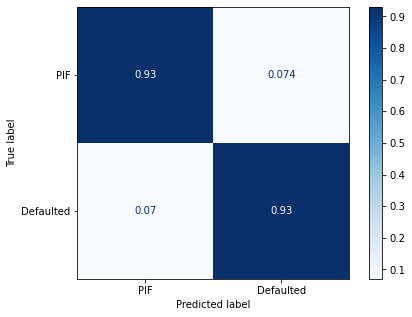

In [29]:
# Cross-validation score for optimized model
dt_cv_bestscore = crossvalbestscore(dt_gscv)
print("\n")

# Fit optimized classifier to training data
dt_opt = dt_gscv.best_estimator_
dt_opt.fit(X_train, y_train)

# Print classification report
print(classification_report(y_test, dt_opt.predict(X_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(dt_opt, X_test, y_test, "true")

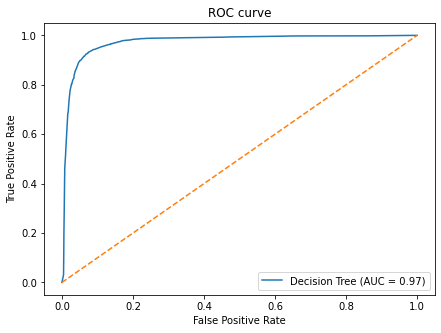

In [276]:
# Plot ROC curve
plt.rcParams['figure.figsize']=[7,5]
roc_auc(X_test, y_test, dt_opt, "Decision Tree")

As seen above, hyperparameter optimization via GridSearchCV results in a 2% improvement in both the model accuracy and the area under the curve. A model accuracy of 92.8% suggests that of the total number of predictions made the model correctly predicts (the loans paid in full and loan defaults) with 92.8% accuracy. The ROC curve plots the true positive rates (y-axis) against the false positive rates (x-axis). The AUC metric evaluation of 0.973 means that the ROC curve for this particular model covers about 97.3% of the area bounded by the curve and the axes, i.e., the model is capable of distinguishing between true loan defaults and false loan defaults (or true loans paid in full) 97% of the time. This is a characteristic of a good model because higher AUC values (range: 0 to 1) suggest more true positive predictions, and hence a model with good prediction capabilities.

The accuracy and AUC metrics are used to evaluate performances of different models. However, for the given data science problem, it is slightly more important to correctly predict loan defaults than the loans paid in full since misclassifying a defaulted loan will result in severe consequences for the SBA and the banks as they both will incur losses if a business defaults on its loan, i.e., it does not pay off the loan in full. Misclassifying a loan paid in full will have less severe consequences in that that the SBA and the banks might miss out on some premiums or interest that they could have earned if they had disbursed loan to a business that in reality would pay the loan in full. Therefore, the performance metric "recall" is also important to keep a check on with an aim to have higher recall values, especially for defaulted loans. The confusion matrix plotted above shows good recall values (0.93) for both loan defaults and loans paid in full.

Note that any dataset with an unequal class distribution is technically imbalanced. Although the dataset "X_train" is technically imbalanced, with slightly more instances for loan defaults (5006) than for loans paid in full (4913), this is not a case of severe/significant imbalance. This imbalance is due to the fact that 80% of the data is chosen at random as the training data during the train-test split and remaining 20% is the test data.

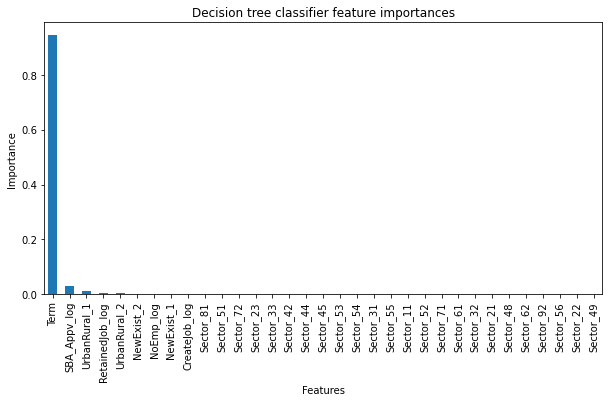

In [31]:
# Plot feature importance
plt.subplots(figsize=(10,5))
dt_feat_imps = dt_opt.feature_importances_
dt_feat_imps = pd.Series(dt_feat_imps, index=X_train.columns).sort_values(ascending=False)
dt_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision tree classifier feature importances');

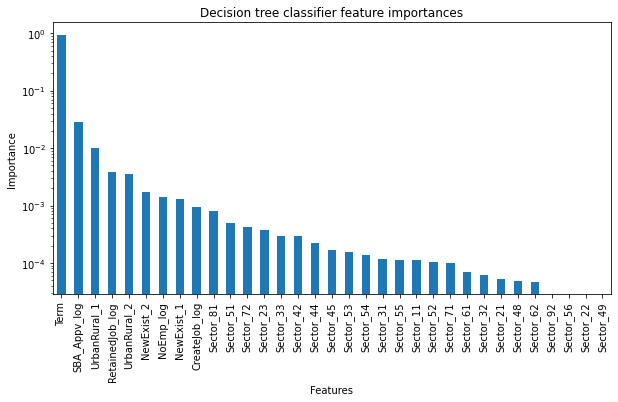

In [32]:
# Plot feature importance on log scale
plt.subplots(figsize=(10,5))
dt_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.yscale("log")
plt.title('Decision tree classifier feature importances');

Plotting the feature importances reveals the feature "Term" to be the most important while others barely have any contributions, with most feature importances being on the order of 10^(-3) and lower. This is investigated further below.

**Generate dataset with feature "Sector_group"**

Since the feature "Sector" does not have a significant contribution in making predictions, the sectors are grouped into three different categories as shown below. This also helps in reducing the number of features used in training, consequently decreasing the computation time.

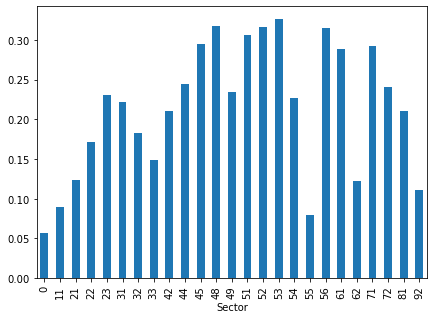

In [33]:
# Define groups for "Sector"
plt.rcParams['figure.figsize']=[7,5]
dfCA.groupby(["Sector"])["Default"].mean().plot(kind="bar");

In [34]:
# Determine group for each sector
tmp_df = dfCA.groupby(["Sector"])["Default"].mean()
ind_1 = tmp_df[tmp_df < 0.10].index
ind_2 = tmp_df[(tmp_df >= 0.10) & (tmp_df < 0.20)].index
ind_3 = tmp_df[tmp_df >= 0.20].index
print(ind_1)
print(ind_2)
print(ind_3)

Int64Index([0, 11, 55], dtype='int64', name='Sector')
Int64Index([21, 22, 32, 33, 62, 92], dtype='int64', name='Sector')
Int64Index([23, 31, 42, 44, 45, 48, 49, 51, 52, 53, 54, 56, 61, 71, 72, 81], dtype='int64', name='Sector')


In [35]:
# Generate new dataframe with "Sector_group" feature
X2_bal = copy.deepcopy(X_bal)
X2_bal["Sector_group"] = "1"
X2_bal.loc[dfCA["Sector"].isin(ind_2), "Sector_group"] = "2"
X2_bal.loc[dfCA["Sector"].isin(ind_3), "Sector_group"] = "3"
X2_bal

,Term,NewExist,UrbanRural,Sector,CreateJob_log,RetainedJob_log,NoEmp_log,SBA_Appv_log,Sector_group
69167,288,1,0,33,0.000000,0.000000,0.301030,5.580698,2
108855,49,2,1,72,0.845098,0.301030,0.301030,5.314396,3
75840,85,1,1,51,0.903090,1.230449,1.000000,5.528275,3
97011,96,1,0,0,0.000000,0.000000,0.845098,5.068190,1
85720,300,1,0,45,0.000000,0.000000,1.113943,5.364560,3
...,...,...,...,...,...,...,...,...,...
19003,51,1,1,54,0.000000,0.301030,0.301030,3.431525,3
11481,33,2,1,62,0.301030,0.477121,0.477121,4.628399,2
38497,84,1,1,54,0.000000,0.301030,0.301030,3.875119,3
28049,29,1,1,72,0.301030,0.477121,0.301030,4.397957,3


In [36]:
# Generate dummy variables for categorical variables
X2_bal_encoded = pd.get_dummies(X2_bal, columns=['Sector_group', 'NewExist', 'UrbanRural'])
X2_bal_encoded

,Term,Sector,CreateJob_log,RetainedJob_log,NoEmp_log,SBA_Appv_log,Sector_group_1,Sector_group_2,Sector_group_3,NewExist_0,NewExist_1,NewExist_2,UrbanRural_0,UrbanRural_1,UrbanRural_2
69167,288,33,0.000000,0.000000,0.301030,5.580698,0,1,0,0,1,0,1,0,0
108855,49,72,0.845098,0.301030,0.301030,5.314396,0,0,1,0,0,1,0,1,0
75840,85,51,0.903090,1.230449,1.000000,5.528275,0,0,1,0,1,0,0,1,0
97011,96,0,0.000000,0.000000,0.845098,5.068190,1,0,0,0,1,0,1,0,0
85720,300,45,0.000000,0.000000,1.113943,5.364560,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19003,51,54,0.000000,0.301030,0.301030,3.431525,0,0,1,0,1,0,0,1,0
11481,33,62,0.301030,0.477121,0.477121,4.628399,0,1,0,0,0,1,0,1,0
38497,84,54,0.000000,0.301030,0.301030,3.875119,0,0,1,0,1,0,0,1,0
28049,29,72,0.301030,0.477121,0.301030,4.397957,0,0,1,0,1,0,0,1,0


In [37]:
# Drop redundant columns
X2_bal_encoded.drop(['Sector', 'Sector_group_1', 'NewExist_0', 'UrbanRural_0'], axis=1,
                    inplace=True)
X2_bal_encoded.shape

(49594, 11)

In [38]:
# Split data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_bal_encoded, y_bal,
                                                        test_size=tsize, random_state=seed)

In [39]:
# Assess performance using cross-validation before hyperparameter optimization
dt2_cv_results = crossval(dt, X2_train, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.909, std = 0.001
AUC: mean = 0.912, std = 0.001


In [40]:
# Optimize hyperparameters via grid search
# Choose a large range for maximum tree depth
params = {'max_depth': [i for i in range(1, 100, 10)]}
dt2_gscv = fit_model(X2_train, y2_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt2_gscv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


DecisionTreeClassifier(max_depth=11, random_state=1)

In [41]:
# Optimize on a smaller range for maximum tree depth
params = {'max_depth': [i for i in range(1, 21)]}
dt2_gscv = fit_model(X2_train, y2_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt2_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    5.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


DecisionTreeClassifier(max_depth=8, random_state=1)

Model accuracy: mean = 0.928, std = 0.003
AUC: mean = 0.974, std = 0.002


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4913
           1       0.93      0.93      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



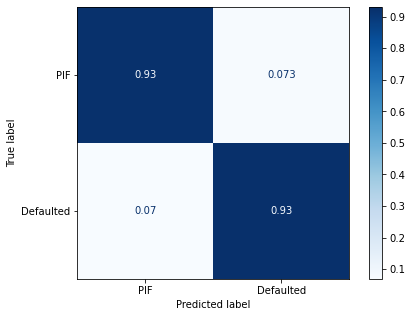

In [42]:
# Cross-validation score for optimized model
dt2_cv_bestscore = crossvalbestscore(dt2_gscv)
print("\n")

# Fit optimized classifier to training data
dt2_opt = dt2_gscv.best_estimator_
dt2_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, dt2_opt.predict(X2_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(dt2_opt, X2_test, y2_test, "true")

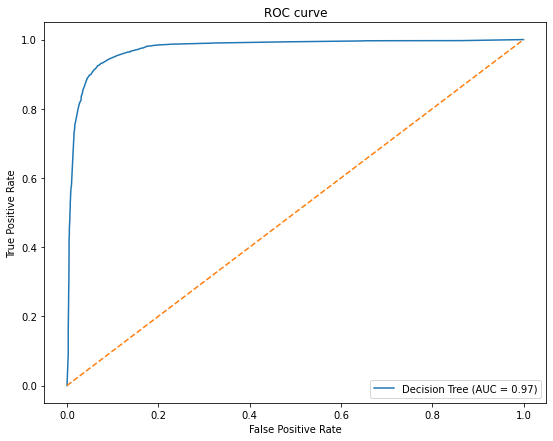

In [283]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers = [dt2_opt]
list_clfnames = ["Decision Tree"]
list_dnames = ["X2_test"]

# Set parameter for scaled data (0: not scaled, 1: scaled)
nzeros = 1
list_dscaled = [0]*nzeros

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                                      list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

Apparently, the model performance is not affected by combining the sectors into groups. There are similar amounts of improvements (of 2% each) in the model accuracy and the AUC.

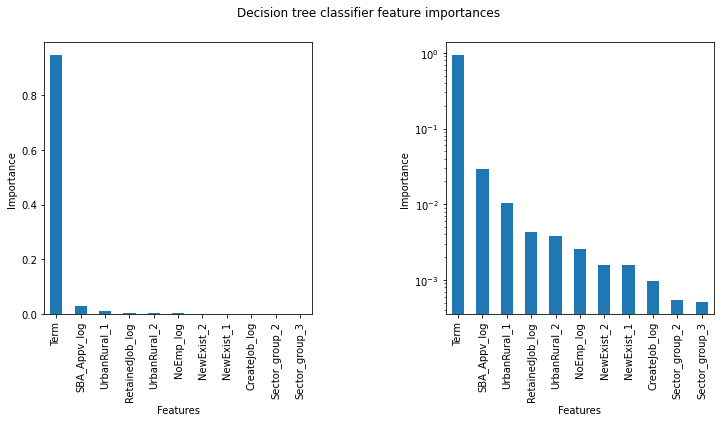

In [45]:
# Plot feature importance
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dt2_feat_imps = dt2_opt.feature_importances_
dt2_feat_imps = pd.Series(dt2_feat_imps, index=X2_train.columns).sort_values(ascending=False)
fig.suptitle('Decision tree classifier feature importances')
dt2_feat_imps.plot(kind='bar', ax=axes[0]).set_xlabel('Features')
axes[0].set_ylabel('Importance')
dt2_feat_imps.plot(kind='bar', ax=axes[1]).set_yscale("log")
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
plt.subplots_adjust(wspace=0.5);

As illustrated above, the feature "Term" is the dominant predictor feature. There is a steep decline in the feature importance from "Term" to "SBA_Appv_log". The decrease in the feature importance is more gradual thereafter. Also, the added feature "Sector_group" is still the least important, suggesting it is acceptable to use information captured about each sector in this collective way.

In [346]:
# Save classification report as a dictionary
dt2_report = classification_report(y2_test, dt2_opt.predict(X2_test), 
                                   target_names=None, output_dict=True)

In [289]:
# Save optimized model
dt_model = dt2_opt
dt_model.X_columns = [col for col in X2_train.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'dt_opt_model.pkl'), 'wb') as file:
    pickle.dump(dt_model, file)
    
#with open(os.path.join(modelpath, 'dt_opt_model.pkl'), 'rb') as file:
#    model = pickle.load(file)

**Generate dataset without "Term" feature**

Since the feature "Term" seems to be the dominant feature in making predictions and siginificantly outweighs the importances of other features, a dataset without the feature "Term" is generated to assess performance of other features in its absence.

In [47]:
# Generate data without "Term" feature
X3_bal_encoded = X2_bal_encoded.drop(["Term"], axis=1)
X3_bal_encoded.keys()

Index(['CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log',
       'Sector_group_2', 'Sector_group_3', 'NewExist_1', 'NewExist_2',
       'UrbanRural_1', 'UrbanRural_2'],
      dtype='object')

In [48]:
# Split data into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_bal_encoded, y_bal,
                                                        test_size=tsize, random_state=seed)

In [49]:
# Assess performance using cross-validation before hyperparameter optimization
dt3_cv_results = crossval(dt, X3_train, y3_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.680, std = 0.003
AUC: mean = 0.674, std = 0.003


In [50]:
# Optimize hyperparameters via grid search
# Choose a large range for maximum tree depth
params = {'max_depth': [i for i in range(1, 100, 10)]}
dt3_gscv = fit_model(X3_train, y3_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt3_gscv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


DecisionTreeClassifier(max_depth=11, random_state=1)

In [51]:
# Optimize on a smaller range for maximum tree depth
params = {'max_depth': [i for i in range(1, 21)]}
dt3_gscv = fit_model(X3_train, y3_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt3_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


DecisionTreeClassifier(max_depth=5, random_state=1)

In [52]:
# Cross-validation score for optimized model
dt3_cv_bestscore = crossvalbestscore(dt3_gscv)
print("\n")

# Fit optimized classifier to training data
dt3_opt = dt3_gscv.best_estimator_
dt3_opt.fit(X3_train, y3_train)

# Print classification report
print(classification_report(y3_test, dt3_opt.predict(X3_test), target_names=None))

Model accuracy: mean = 0.753, std = 0.003
AUC: mean = 0.796, std = 0.004


              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4913
           1       0.75      0.78      0.76      5006

    accuracy                           0.75      9919
   macro avg       0.76      0.75      0.75      9919
weighted avg       0.76      0.75      0.75      9919



As expected, the model performance has decreased significantly (accuracy by 17.5%, AUC by 17.8%) due to the removal of the most important feature "Term".

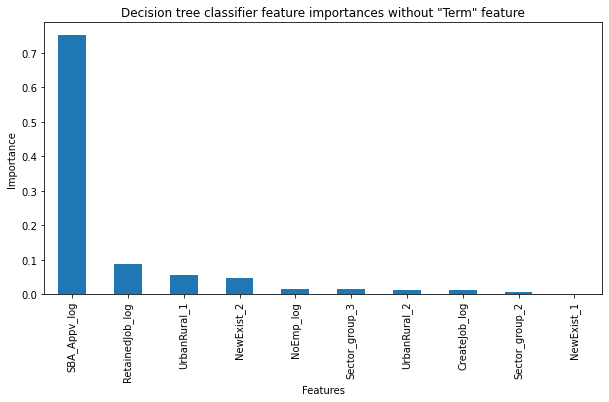

In [54]:
# Plot feature importance
plt.subplots(figsize=(10,5))
dt3_feat_imps = dt3_opt.feature_importances_
dt3_feat_imps = pd.Series(dt3_feat_imps, index=X3_train.columns).sort_values(ascending=False)
dt3_feat_imps.plot(kind='bar').set_xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision tree classifier feature importances without "Term" feature');

The feature "SBA_Appv_log" appears to be second most important feature (after "Term") dominating the prediction capability of the model. Similar to the feature "Term", the feature "SBA_Appv_log" significantly outweighs the other features in terms of feature importance.

**Generate dataset without "Term" and "SBA_Appv_log" features**

So far the two most important features have turned out to be numerical features. To assess the performance of the remaining features, a dataset is generated without the numerical features "Term" and "SBA_Appv_log".

In [55]:
# Generate data without "Term" and "SBA_Appv_log" features
X4_bal_encoded = X3_bal_encoded.drop(["SBA_Appv_log"], axis=1)
X4_bal_encoded.keys()

Index(['CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'Sector_group_2',
       'Sector_group_3', 'NewExist_1', 'NewExist_2', 'UrbanRural_1',
       'UrbanRural_2'],
      dtype='object')

In [56]:
# Split data into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4_bal_encoded, y_bal,
                                                        test_size=tsize, random_state=seed)

In [57]:
# Assess performance using cross-validation before hyperparameter optimization
dt4_cv_results = crossval(dt, X4_train, y4_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.694, std = 0.006
AUC: mean = 0.721, std = 0.007


In [58]:
# Optimize hyperparameters via grid search
# Choose a large range for maximum tree depth
params = {'max_depth': [i for i in range(1, 100, 10)]}
dt4_gscv = fit_model(X4_train, y4_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt4_gscv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.6s finished


DecisionTreeClassifier(max_depth=11, random_state=1)

In [59]:
# Optimize on a smaller range for maximum tree depth
params = {'max_depth': [i for i in range(1, 21)]}
dt4_gscv = fit_model(X4_train, y4_train, dt, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
dt4_gscv.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


DecisionTreeClassifier(max_depth=6, random_state=1)

In [60]:
# Cross-validation score for optimized model
dt4_cv_bestscore = crossvalbestscore(dt4_gscv)
print("\n")

# Fit optimized classifier to training data
dt4_opt = dt4_gscv.best_estimator_
dt4_opt.fit(X4_train, y4_train)

# Print classification report
print(classification_report(y4_test, dt4_opt.predict(X4_test), target_names=None))

Model accuracy: mean = 0.705, std = 0.006
AUC: mean = 0.749, std = 0.007


              precision    recall  f1-score   support

           0       0.76      0.62      0.68      4913
           1       0.68      0.81      0.74      5006

    accuracy                           0.71      9919
   macro avg       0.72      0.71      0.71      9919
weighted avg       0.72      0.71      0.71      9919



The model accuracy and the AUC decrease less significantly by 4.8% and 4.7%, respectively, than the scenario when only the feature "Term" is removed. It also interesting to see that the recall score for the defaulted loans is still good at 81%, and is 3% more than the recall score for the dataset when only the feature "Term" is removed. This suggests that the remaining features can make accurate predictions for potential loan defaults.

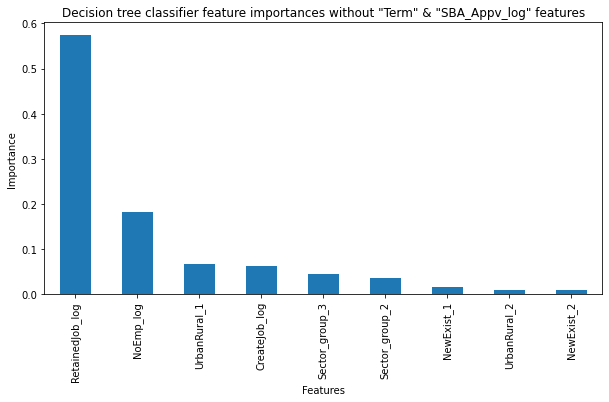

In [62]:
# Plot feature importance
plt.rcParams['figure.figsize']=[10,5]
dt4_feat_imps = dt4_opt.feature_importances_
dt4_feat_imps = pd.Series(dt4_feat_imps, index=X4_train.columns).sort_values(ascending=False)
dt4_feat_imps.plot(kind='bar').set_xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision tree classifier feature importances without "Term" & "SBA_Appv_log" \
features');

Plotting the feature importances for the dataset "X4_train" reveals the feature "RetainedJob_log" as the dominant feature followed by a steep decline to the feature "NoEmp_log", and then a more gradual decrease in the other feature importances. 

**Summary:** The optimal decision tree classifier for the dataset "X2_train" is "dt2_opt" (max_depth=8) with a model accuracy of 92.8%, AUC of 97.3%, and recall values of 93% for both loan defaults and loans paid in full.

**Learning curve**

A learning curve refers to a plot of the prediction accuracy/error of a model against the number of training instances/examples used for learning. It is a useful tool to find how much a model benefits from adding more training data. When both the validation score and the training score start to converge to a value, it is an indication that the model will not benefit much from more training data.

As seen in the plot below, the model performance does not improve much from more training data after about 20,000 training examples, since both the validation score and the training score start to plateau around a value of 93%.

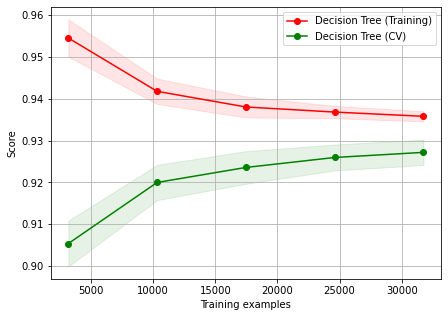

In [63]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = dt2_opt
classifierName = "Decision Tree"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X2_train, y2_train)

### 6.2 Ensemble Methods - Random Forest<a id='6.2_Ensemble_Methods_Random_Forest'></a>

In [64]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
# max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
# random_state=None, verbose=0, warm_start=False, class_weight=None,
# ccp_alpha=0.0, max_samples=None)

# Initialize classifier to use all features (set max_features=None)
rf_mfn = RandomForestClassifier(max_features=None, random_state=seed)

# Initialize classifier with max_features set to default value
rf_mfa = RandomForestClassifier(random_state=seed)

The main parameters to adjust when using random forest classifier are "n_estimators" and "max_features". The scikit-learn documentation also suggests that an empirical good default value is max_features="sqrt" (using a random subset of size sqrt(number of features)) for classification tasks. Since the number of features for the given data science problem is not too large, the dataset is tested with two models: one, using all the features during training called "rf_mfn"; and second, using a random subset of size sqrt(number of features) called "rf_mfa".

In [65]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train" training data
verb = 1
list_rf_classifier = [rf_mfn, rf_mfa]

for classifier in list_rf_classifier:
    print(f"Classifier: {classifier}")
    start = time.time()
    rf2_cv_results = crossval(classifier, X2_train, y2_train, cv, scoring_fnc, n_jobs, verb)
    print(f"Computation time: {format(time.time() - start, '.2f')} s\n")

Classifier: RandomForestClassifier(max_features=None, random_state=1)
Model accuracy: mean = 0.929, std = 0.002
AUC: mean = 0.977, std = 0.002
Computation time: 20.96 s

Classifier: RandomForestClassifier(random_state=1)
Model accuracy: mean = 0.919, std = 0.003
AUC: mean = 0.973, std = 0.002
Computation time: 11.08 s



The model "rf_mfn" that uses all the features during training performs better than the model "rf_mfa" that uses a random subset of the features ("auto" = sqrt(number of features)). Moreover, the former model also takes more computation time since it uses all the features.

**Hyperparameter optimization for "X2_train" training data**

In [66]:
# Optimize hyperparameters via grid search without setting maximum depth of trees
# Choose a range for number of estitmators
params = {'n_estimators': [n for n in range(10,110,10)]}
rf2_gscv_results = []

for classifier in list_rf_classifier:
    print(f"Classifier: {classifier}")
    rf2_gscv = fit_model(X2_train, y2_train, classifier, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
    rf2_gscv_results.append(rf2_gscv.cv_results_)

Classifier: RandomForestClassifier(max_features=None, random_state=1)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Classifier: RandomForestClassifier(random_state=1)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.6s finished


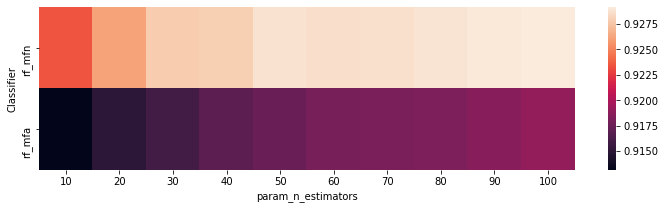

In [67]:
# Display results sorted by "mean_test_Accuracy"
rf2_gscv_results_listdf = []
for classifier, result in zip(list_rf_classifier, rf2_gscv_results):
    results_df = pd.DataFrame(result).sort_values(by=['rank_test_Accuracy'])
    results_df = (results_df.set_index(results_df["params"].apply(
                  lambda x: "_".join(str(val) for val in x.values()))).
                  rename_axis('n_estimators'))
    rf2_gscv_results_listdf.append(results_df)

# Create one dataframe for all results
rf2_gscv_results_df = pd.concat({"rf_mfn": rf2_gscv_results_listdf[0], 
                                 "rf_mfa": rf2_gscv_results_listdf[1]}, 
                                names=["Classifier"])

# Plot heatmap to display model performance using different hyperparameter combinations
max_scores = rf2_gscv_results_df.groupby(["Classifier", "param_n_estimators"]).max()
max_scores = max_scores.unstack()["mean_test_Accuracy"]
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(max_scores);

In [68]:
# Print difference between highest and lowest accuracy
print('Difference between highest and lowest accuracy for "rf_mfn": %s' %\
      (np.round(rf2_gscv_results_df.loc["rf_mfn", "mean_test_Accuracy"].max() - \
                rf2_gscv_results_df.loc["rf_mfn", "mean_test_Accuracy"].min(), 4)))
print('Difference between highest and lowest accuracy for "rf_mfa": %s' %\
      (np.round(rf2_gscv_results_df.loc["rf_mfa", "mean_test_Accuracy"].max() - \
                rf2_gscv_results_df.loc["rf_mfa", "mean_test_Accuracy"].min(), 4)))

Difference between highest and lowest accuracy for "rf_mfn": 0.0057
Difference between highest and lowest accuracy for "rf_mfa": 0.0059


As seen in the heat map, the model "rf_mfn" that uses all the features during training performs better than the model "rf_mfa" that uses a random subset of the features ("auto" = sqrt(number of features)). However, the improvement in accuracy is only about 1.08% on average across a range of number of estimators from 10 to 100, with increments of 10 estimators. For both the models, using 100 estimators gives the best performance accuracy. But given that the difference between the highest accuracy (100 estimators) and lowest accuracy (10 estimators) for both models is very small (0.0057 and 0.0059), the model might be overfitting when using more than 10 estimators. Therefore, 10 estimators should suffice for both models.

Model accuracy: mean = 0.923, std = 0.003
AUC: mean = 0.969, std = 0.002


              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4913
           1       0.93      0.92      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



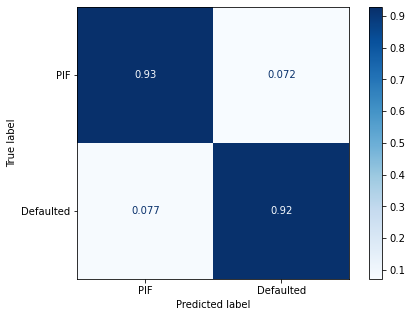

In [69]:
# Cross-validation for optimized model "rf_mfn" with 10 estimators
rf2_mfn_opt = RandomForestClassifier(n_estimators=10, max_features=None, random_state=seed)
rf2_mfn_opt_cv_results = crossval(rf2_mfn_opt, X2_train, y2_train, 
                                  cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized classifier to training data
rf2_mfn_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, rf2_mfn_opt.predict(X2_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf2_mfn_opt, X2_test, y2_test, "true")

Model accuracy: mean = 0.913, std = 0.002
AUC: mean = 0.965, std = 0.002


              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4913
           1       0.92      0.90      0.91      5006

    accuracy                           0.91      9919
   macro avg       0.91      0.91      0.91      9919
weighted avg       0.91      0.91      0.91      9919



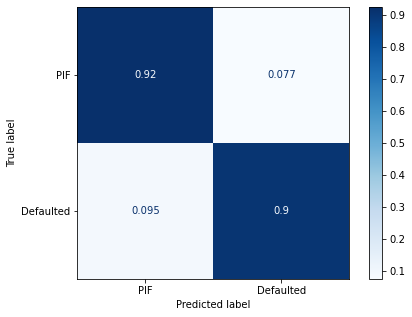

In [70]:
# Cross validation for optimized model with "rf_mfa" with 10 estimators
rf2_mfa_opt = RandomForestClassifier(n_estimators=10, random_state=seed)
rf2_mfa_opt_cv_results = crossval(rf2_mfa_opt, X2_train, y2_train, 
                                  cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized classifier to training data
rf2_mfa_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, rf2_mfa_opt.predict(X2_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf2_mfa_opt, X2_test, y2_test, "true")

The precision and recall scores for the model "rf_mfn" are better than the model "rf_mfa". Hence, the former is the preferred model for the given problem.

Since the optimal maximum tree-depth for the decision tree model is known, the parameter "max_depth" is also treated as a hyperparameter that is optimized via cross-validation (as shown below).

In [71]:
# Optimize hyperparameters via grid search using classifier "rf_mfn"
# Choose a range for number of estitmators
# Choose a range for maximum tree-depth around the optimal value from Decision Tree classifier
params = {'n_estimators': [n for n in range(10,110,10)], 
          'max_depth': [i for i in range(5,16)]}
rf2_mfn_gscv = fit_model(X2_train, y2_train, rf_mfn, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
rf2_mfn_gscv.best_estimator_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed: 17.3min finished


RandomForestClassifier(max_depth=12, max_features=None, n_estimators=90,
                       random_state=1)

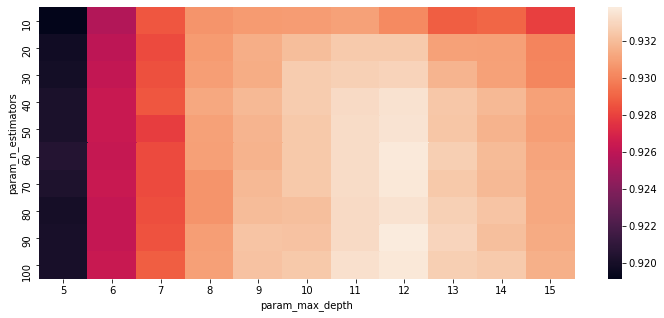

In [72]:
# Plot heatmap to display model performance using different hyperparameter combinations
rf2_mfn_gscv_results_df = pd.DataFrame(rf2_mfn_gscv.cv_results_)
max_scores = rf2_mfn_gscv_results_df.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,5]
sns.heatmap(max_scores);

Plotting a heat map of the cross-validation results gives a nice overview of the model performance for different parameter combinations. This can help in choosing certain parameter combinations when considering the overall computional intensity and complexity of the model. For example, when dealing with limited computational resources and time, a relatively simpler and faster model can be used by selecting the corresponding parameter combinations like few number of estimators with a smaller maximum tree-depth.

In [73]:
# Extract indices for certain max_depth and n_estimators to check for optimal values
opt_max_depth = 12
list_n_estimators = [n for n in range(60,110,10)]
for (index, d) in enumerate(rf2_mfn_gscv.cv_results_["params"]):
    for k in list_n_estimators:
        if (d["max_depth"] == opt_max_depth) & (d["n_estimators"] == k):
            print("Index for max_depth: %s and n_estimators: %s = %s" %\
                  (opt_max_depth, k, index))

Index for max_depth: 12 and n_estimators: 60 = 75
Index for max_depth: 12 and n_estimators: 70 = 76
Index for max_depth: 12 and n_estimators: 80 = 77
Index for max_depth: 12 and n_estimators: 90 = 78
Index for max_depth: 12 and n_estimators: 100 = 79


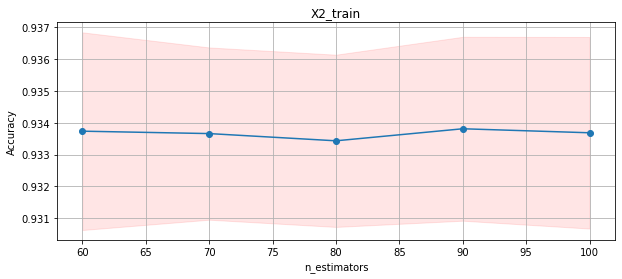

In [74]:
# Plot accuracy scores with standard deviations
plt.rcParams['figure.figsize']=[10,4]
train_scores_mean = rf2_mfn_gscv.cv_results_["mean_test_Accuracy"][75:80]
train_scores_std = rf2_mfn_gscv.cv_results_["std_test_Accuracy"][75:80]
plt.plot(list_n_estimators, train_scores_mean, 'o-')
plt.grid()
plt.fill_between(list_n_estimators, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("X2_train");

Since the improvement in model accuracy when using 60 estimators and the (optimal) 90 estimators is very small, the former is preferred for computational speedup and to avoid any possible overfitting. This is also confirmed by the same precision and recall scores (93% each) for both the optimized models as shown below.

In [75]:
# Cross-validation for optimized model with 60 estimators
print("Cross-validation with 60 estimators:")
rf2_mfn_opt = RandomForestClassifier(n_estimators=60, max_depth=12, max_features=None, 
                                     random_state=seed)
rf2_mfn_opt_cv_results = crossval(rf2_mfn_opt, X2_train, y2_train, 
                                  cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized classifier to training data
rf2_mfn_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, rf2_mfn_opt.predict(X2_test), target_names=None))

print("\n")

# Cross-validation score for optimized model (90 estimators)
print("Cross-validation with 90 estimators:")
rf2_mfn_cv_bestscore = crossvalbestscore(rf2_mfn_gscv)
print("\n")

# Fit optimized classifier to training data
rf2_mfn_90 = rf2_mfn_gscv.best_estimator_
rf2_mfn_90.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, rf2_mfn_90.predict(X2_test), target_names=None))

Cross-validation with 60 estimators:
Model accuracy: mean = 0.934, std = 0.003
AUC: mean = 0.981, std = 0.002


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4913
           1       0.93      0.93      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



Cross-validation with 90 estimators:
Model accuracy: mean = 0.934, std = 0.003
AUC: mean = 0.981, std = 0.002


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4913
           1       0.93      0.93      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



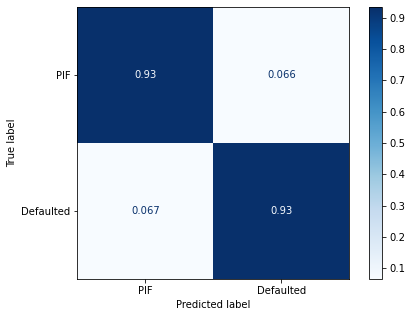

In [76]:
# Plot confusion matrix for test data using the optimized model
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf2_mfn_opt, X2_test, y2_test, "true")

In [347]:
# Save classification report as a dictionary
rf2_mfn_report = classification_report(y2_test, rf2_mfn_opt.predict(X2_test), 
                                       target_names=None, output_dict=True)

An approach similar to the one above is followed for the model "rf_mfa":

In [77]:
# Optimize hyperparameters via grid search using classifier "rf_mfa"
# Choose a range for number of estitmators
# Choose a range for maximum tree-depth around the optimal value from Decision Tree classifier
params = {'n_estimators': [n for n in range(10,110,10)], 
          'max_depth': [i for i in range(5,16)]}
rf2_mfa_gscv = fit_model(X2_train, y2_train, rf_mfa, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
rf2_mfa_gscv.best_estimator_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  7.6min finished


RandomForestClassifier(max_depth=15, random_state=1)

Note that if the model does not print out an optimized value for a hyperparameter, this means the optimized value is infact the default parameter value.

Since the optimal values for both the hyperparameters appears at the end of their respective range of values, the range for each of these parameters is increased to assess if there is further improvement in the model performance.

In [78]:
# Increase range for number of estitmators and maximum tree-depth
params = {'n_estimators': [n for n in range(10,160,10)], 
          'max_depth': [i for i in range(5,21)]}
rf2_mfa_gscv = fit_model(X2_train, y2_train, rf_mfa, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
rf2_mfa_gscv.best_estimator_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 26.7min finished


RandomForestClassifier(max_depth=17, random_state=1)

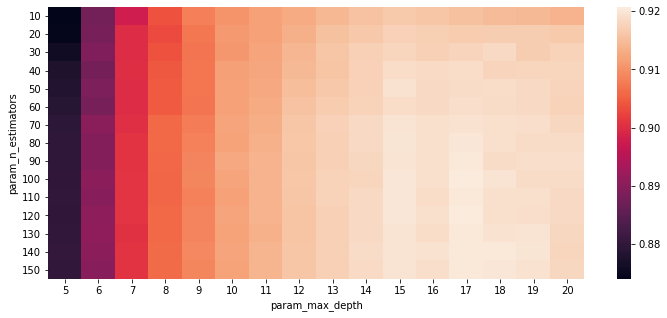

In [79]:
# Plot heatmap to display model performance using different hyperparameter combinations
rf2_mfa_gscv_results_df = pd.DataFrame(rf2_mfa_gscv.cv_results_)
max_scores = rf2_mfa_gscv_results_df.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,5]
sns.heatmap(max_scores);

A heat map of the model's accuracy for different hyperparameter combinations reveals there might be very little improvement between the optimal maximum tree-depth of 17 vs. the previous value of 15. A closer look at the accuracy scores of these two tree-depths corroborates this statement.

In [80]:
# Extract indices for certain max_depth and n_estimators to check for optimal values
list_max_depth = [15, 17]
list_n_estimators = [n for n in range(50,110,10)]
for (index, d) in enumerate(rf2_mfa_gscv.cv_results_["params"]):
    for k in list_n_estimators:
        for i in list_max_depth:
            if (d["max_depth"] == i) & (d["n_estimators"] == k):
                print("Index for max_depth: %s and n_estimators: %s = %s" %(i, k, index))

Index for max_depth: 15 and n_estimators: 50 = 154
Index for max_depth: 15 and n_estimators: 60 = 155
Index for max_depth: 15 and n_estimators: 70 = 156
Index for max_depth: 15 and n_estimators: 80 = 157
Index for max_depth: 15 and n_estimators: 90 = 158
Index for max_depth: 15 and n_estimators: 100 = 159
Index for max_depth: 17 and n_estimators: 50 = 184
Index for max_depth: 17 and n_estimators: 60 = 185
Index for max_depth: 17 and n_estimators: 70 = 186
Index for max_depth: 17 and n_estimators: 80 = 187
Index for max_depth: 17 and n_estimators: 90 = 188
Index for max_depth: 17 and n_estimators: 100 = 189


In [81]:
# Print difference between accuracy scores
rf2_mfa_gscv.cv_results_["mean_test_Accuracy"][184:190] -\
rf2_mfa_gscv.cv_results_["mean_test_Accuracy"][154:160]

array([-0.00078135,  0.00025205, -0.00015123,  0.00010082,  0.0005041 ,
        0.00063012])

In [82]:
# Print accuracy scores for maximum tree-depth of 15
np.round(rf2_mfa_gscv.cv_results_["mean_test_Accuracy"][154:160], 4)

array([0.9195, 0.919 , 0.9197, 0.9199, 0.9198, 0.9201])

The accuracy scores do not seem to significantly improve after 50-70 number of estimators. Setting the value for the optimal number of estimators as 70 should suffice.

Cross-validation with 70 estimators:
Model accuracy: mean = 0.920, std = 0.003
AUC: mean = 0.975, std = 0.002


              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4913
           1       0.92      0.93      0.92      5006

    accuracy                           0.92      9919
   macro avg       0.92      0.92      0.92      9919
weighted avg       0.92      0.92      0.92      9919



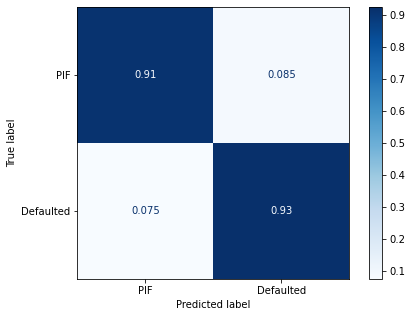

In [83]:
# Cross-validation for optimized model with 70 estimators
print("Cross-validation with 70 estimators:")
rf2_mfa_opt = RandomForestClassifier(n_estimators=70, max_depth=15, random_state=seed)
rf2_mfa_opt_cv_results = crossval(rf2_mfa_opt, X2_train, y2_train, 
                                  cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized classifier to training data
rf2_mfa_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, rf2_mfa_opt.predict(X2_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf2_mfa_opt, X2_test, y2_test, "true")

In [348]:
# Save classification report as a dictionary
rf2_mfa_report = classification_report(y2_test, rf2_mfa_opt.predict(X2_test), 
                                       target_names=None, output_dict=True)

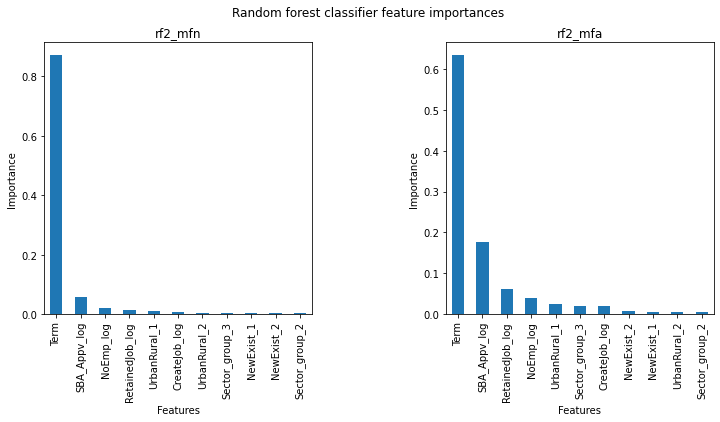

In [118]:
# Plot feature importance
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
rf2_mfn_feat_imps = pd.Series(rf2_mfn_opt.feature_importances_, 
                          index=X2_train.columns).sort_values(ascending=False)
rf2_mfa_feat_imps = pd.Series(rf2_mfa_opt.feature_importances_, 
                          index=X2_train.columns).sort_values(ascending=False)
fig.suptitle('Random forest classifier feature importances')
rf2_mfn_feat_imps.plot(kind='bar', ax=axes[0]).set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('rf2_mfn')
rf2_mfa_feat_imps.plot(kind='bar', ax=axes[1]).set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('rf2_mfa')
plt.subplots_adjust(wspace=0.5);

As expected, the features "Term" and "SBA_Appv_log" are the two most important features affecting the model's prediction accuracy. While the feature "Term" clearly dominates when the model uses all the features ("rf_mfn") during training, there is slightly more gradual decline in the feature importances when the model uses a random subset of the features ("rf_mfa") during training.

**Which model to choose?** Since there is about 1.4% and 0.6% improvement in accuracy and [precision, recall], respectively, with a random forest model that uses all the features during training, we can choose that model. But there is a trade-off of having more computational time - about 17 minutes (for "rf_mfn") vs. about 8 minutes (for "rf_mfa") during hyperparameter optimization with the same set of parameters. If there are resources and time available to run a more expensive model, one should select the (slightly) better model.

**Summary:** The optimal "rf_mfn" model for the dataset "X2_train" has parameters n_estimators=60 and max_depth=12. The optimal "rf_mfa" model has parameters n_estimators=70 and max_depth=15.

In [290]:
# Save optimized models
rfm_model = rf2_mfn_opt
rfm_model.X_columns = [col for col in X2_train.columns]
rfa_model = rf2_mfa_opt
rfa_model.X_columns = [col for col in X2_train.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'rfm_opt_model.pkl'), 'wb') as file:
    pickle.dump(rfm_model, file)
with open(os.path.join(modelpath, 'rfa_opt_model.pkl'), 'wb') as file:
    pickle.dump(rfa_model, file)

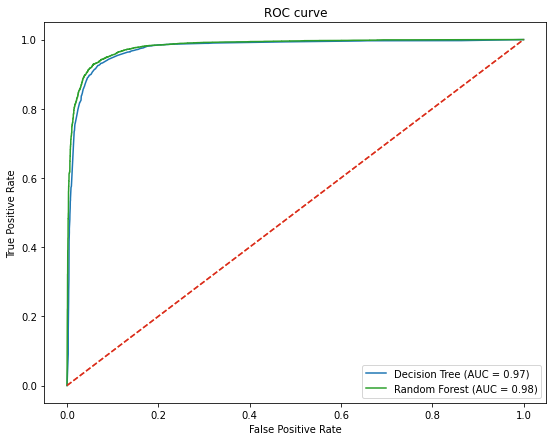

In [284]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers.append(rf2_mfn_opt)
list_clfnames.append("Random Forest")
list_dnames.append("X2_test")
list_dscaled.append(0)

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                               list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

**Hyperparameter optimization for "X4_train" training data**

Assess the performance of random forest models on the dataset "X4_train":

In [88]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X4_train" training data
verb = 1
list_rf_classifier = [rf_mfn, rf_mfa]

for classifier in list_rf_classifier:
    print(f"Classifier: {classifier}")
    start = time.time()
    rf4_cv_results = crossval(classifier, X4_train, y4_train, cv, scoring_fnc, n_jobs, verb)
    print(f"Computation time: {format(time.time() - start, '.2f')} s\n")

Classifier: RandomForestClassifier(max_features=None, random_state=1)
Model accuracy: mean = 0.698, std = 0.007
AUC: mean = 0.738, std = 0.007
Computation time: 17.77 s

Classifier: RandomForestClassifier(random_state=1)
Model accuracy: mean = 0.698, std = 0.007
AUC: mean = 0.737, std = 0.007
Computation time: 9.23 s



In [89]:
# Optimize hyperparameters via grid search using classifier "rf_mfn"
# Choose a range for number of estitmators
# Choose a range for maximum tree-depth around the optimal value from Decision Tree classifier
params = {'n_estimators': [n for n in range(10,110,10)], 
          'max_depth': [i for i in range(5,16)]}
rf4_mfn_gscv = fit_model(X4_train, y4_train, rf_mfn, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
rf4_mfn_gscv.best_estimator_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  9.3min finished


RandomForestClassifier(max_depth=8, max_features=None, n_estimators=50,
                       random_state=1)

Model accuracy: mean = 0.707, std = 0.005
AUC: mean = 0.757, std = 0.007


              precision    recall  f1-score   support

           0       0.77      0.61      0.68      4913
           1       0.68      0.82      0.74      5006

    accuracy                           0.72      9919
   macro avg       0.72      0.71      0.71      9919
weighted avg       0.72      0.72      0.71      9919



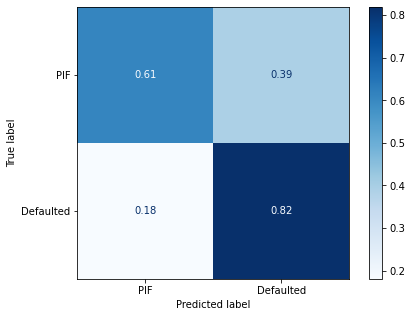

In [90]:
# Cross-validation score for optimized model
rf4_mfn_cv_bestscore = crossvalbestscore(rf4_mfn_gscv)
print("\n")

# Fit optimized classifier to training data
rf4_mfn_opt = rf4_mfn_gscv.best_estimator_
rf4_mfn_opt.fit(X4_train, y4_train)

# Print classification report
print(classification_report(y4_test, rf4_mfn_opt.predict(X4_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf4_mfn_opt, X4_test, y4_test, "true")

In [91]:
# Optimize hyperparameters via grid search using classifier "rf_mfa"
# Choose a range for number of estitmators
# Choose a range for maximum tree-depth around the optimal value from Decision Tree classifier
params = {'n_estimators': [n for n in range(10,110,10)], 
          'max_depth': [i for i in range(5,16)]}
rf4_mfa_gscv = fit_model(X4_train, y4_train, rf_mfa, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
rf4_mfa_gscv.best_estimator_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  6.3min finished


RandomForestClassifier(max_depth=8, n_estimators=60, random_state=1)

Model accuracy: mean = 0.708, std = 0.006
AUC: mean = 0.758, std = 0.008


              precision    recall  f1-score   support

           0       0.76      0.63      0.69      4913
           1       0.69      0.81      0.74      5006

    accuracy                           0.72      9919
   macro avg       0.72      0.72      0.71      9919
weighted avg       0.72      0.72      0.71      9919



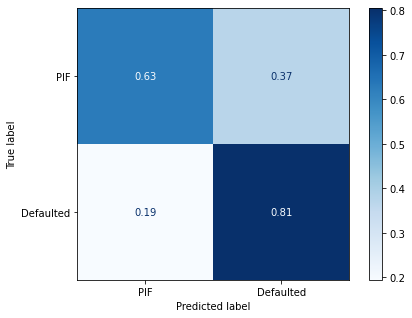

In [92]:
# Cross-validation score for optimized model
rf4_mfa_cv_bestscore = crossvalbestscore(rf4_mfa_gscv)
print("\n")

# Fit optimized classifier to training data
rf4_mfa_opt = rf4_mfa_gscv.best_estimator_
rf4_mfa_opt.fit(X4_train, y4_train)

# Print classification report
print(classification_report(y4_test, rf4_mfa_opt.predict(X4_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(rf4_mfa_opt, X4_test, y4_test, "true")

As seen with the case for the dataset "X2_train" (having all features including "Term" and "SBA_Appv_log"), the recall score for the defaulted loans is still good - 82% ("rf_mfn") and 81% ("rf_mfa"). This suggests that the other features can make good predictions for potential loan defaults.

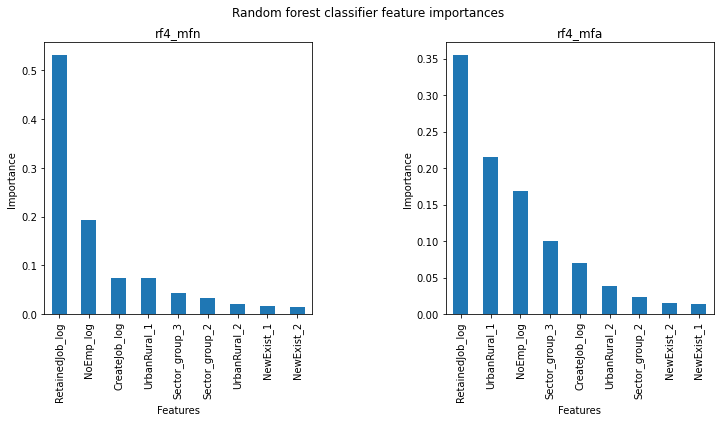

In [94]:
# Plot feature importance
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
rf4_mfn_feat_imps = pd.Series(rf4_mfn_opt.feature_importances_, 
                          index=X4_train.columns).sort_values(ascending=False)
rf4_mfa_feat_imps = pd.Series(rf4_mfa_opt.feature_importances_, 
                          index=X4_train.columns).sort_values(ascending=False)
fig.suptitle('Random forest classifier feature importances')
rf4_mfn_feat_imps.plot(kind='bar', ax=axes[0]).set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('rf4_mfn')
rf4_mfa_feat_imps.plot(kind='bar', ax=axes[1]).set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('rf4_mfa')
plt.subplots_adjust(wspace=0.5);

Plotting the feature importances for the dataset "X4_train" reveals the feature "RetainedJob_log" as the dominant feature for both the models "rf_mfn" and "rf_mfa". This is followed by a steep decline to the feature "NoEmp_log" for the model "rf_mfn", and then a more gradual decrease in the other feature importances. But there is more gradual decrease in feature importances for the model "rf_mfa" with the feature "UrbanRural_1" being slightly more important than the feature "NoEmp_log".

Looking at feature importances for all the datasets so far suggests that the feature "Term" is the dominant feature affecting a model's prediction accuracy, followed by the feature "SBA_Appv_log". The top three features are: "RetainedJob_log", "NoEmp_log" and "UrbanRural_1".

**Summary:** The optimal random forest classifier for the dataset "X2_train" is "rf2_mfn_opt" (n_estimators=60, max_depth=12, max_features=None) with a model accuracy of 93.4%, AUC of 98.1%, and recall values of 93% for both loan defaults and loans paid in full.

**Learning curve**

The model performance seems to start to plateau after about 25,000 training examples.

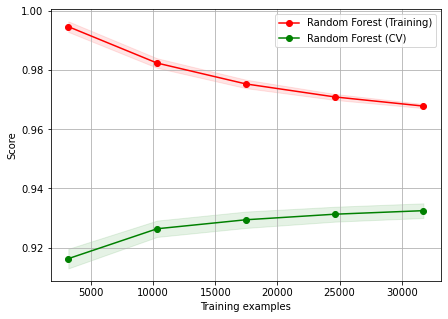

In [95]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = rf2_mfn_opt
classifierName = "Random Forest"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X2_train, y2_train)

### 6.3 Ensemble Methods - AdaBoost<a id='6.3_Ensemble_Methods_AdaBoost'></a>

In [96]:
from sklearn.ensemble import AdaBoostClassifier
from numpy import arange

# AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0,
# algorithm='SAMME.R', random_state=None)
dtc = DecisionTreeClassifier(max_depth=1, random_state=seed)
abc = AdaBoostClassifier(base_estimator=dtc, random_state=seed)

In [97]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train" training data
abc2_cv_results = crossval(abc, X2_train, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.911, std = 0.003
AUC: mean = 0.967, std = 0.001


In [98]:
# Hyperparameter optimization of "X2_train" dataset
# Optimize maximum tree-depth of base estimator, and number of estimators 
# (trees) via grid search
params = {'base_estimator': [DecisionTreeClassifier(max_depth=d, random_state=seed) \
                             for d in range(1,11)],
          'n_estimators': [50, 100, 250, 500]}
abc2_gscv = fit_model(X2_train, y2_train, abc, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
abc2_gscv.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 29.5min finished


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   n_estimators=250, random_state=1)

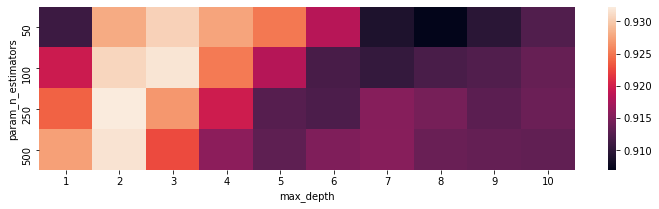

In [99]:
# Plot heatmap to display model performance using different hyperparameter combinations
abc2_gscv_results = pd.DataFrame(abc2_gscv.cv_results_)
abc2_gscv_results = pd.concat([abc2_gscv_results, pd.Series(
    [dt.max_depth for dt in abc2_gscv_results["param_base_estimator"]])], axis=1)
abc2_gscv_results.columns = [*abc2_gscv_results.columns[:-1], "max_depth"]
abc2_max_scores = abc2_gscv_results.groupby(['param_n_estimators', 'max_depth']).max()
abc2_max_scores = abc2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(abc2_max_scores);

In [100]:
# Print accuracy scores some indices
abc2_max_scores.loc[100:500, 2:3]

max_depth,2,3
param_n_estimators,,
100,0.930863,0.931821
250,0.932275,0.926856
500,0.931695,0.922722


The accuracy scores are quite stable for the number of estimators 100, 250, and 500, and a maximum tree-depth of 2 and 3. Cross-validation via grid search estimates the optimal number of estimators to be 250 and a maximum tree-depth of 2. The other parameter combination with an equivalently good accuracy score is 100 estimators and a maximum depth of 3. Since the main idea for using an ensemble method is to use a combination of many weak learners, either parameter combination can be selected based on the computational intensity.

In [101]:
# Print estimated mean fit times
print("Estimated mean fit time for n_estimators=100, max_depth=3:")
display(abc2_gscv_results[(abc2_gscv_results["param_n_estimators"]==100) 
                          & (abc2_gscv_results["max_depth"]==3)][["mean_test_Accuracy", 
                                                                  "mean_fit_time"]])

print("Estimated mean fit time for n_estimators=250, max_depth=2:")
display(abc2_gscv_results[(abc2_gscv_results["param_n_estimators"]==250) 
                          & (abc2_gscv_results["max_depth"]==2)][["mean_test_Accuracy", 
                                                                  "mean_fit_time"]])

Estimated mean fit time for n_estimators=100, max_depth=3:


,mean_test_Accuracy,mean_fit_time
9,0.931821,10.834952


Estimated mean fit time for n_estimators=250, max_depth=2:


,mean_test_Accuracy,mean_fit_time
6,0.932275,19.661449


As seen above, the estimated mean fit time for 250 estimators with maximum tree-depth of 2 is greater than that for 100 estimators with maximum tree-depth of 3. Therefore, to save computational time and resources, and to prevent any potential overfitting, the optimal parameter values are chosen to be: n_estimators=100, max_depth=3.

Model accuracy: mean = 0.932, std = 0.001
AUC: mean = 0.976, std = 0.001


              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4913
           1       0.94      0.93      0.93      5006

    accuracy                           0.93      9919
   macro avg       0.93      0.93      0.93      9919
weighted avg       0.93      0.93      0.93      9919



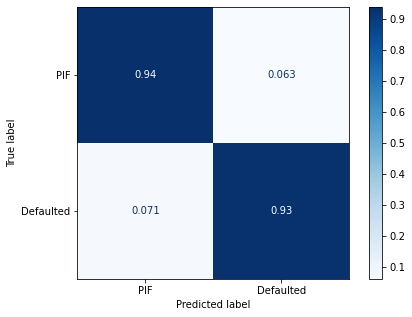

In [102]:
# Cross-validation for optimized model
dtc3 = DecisionTreeClassifier(max_depth=3, random_state=seed)
abc2_opt = AdaBoostClassifier(base_estimator=dtc3, n_estimators=100, random_state=seed)
abc2_opt_cv_results = crossval(abc2_opt, X2_train, y2_train, cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized logistic regression classifier to training data
abc2_opt.fit(X2_train, y2_train)

# Print classification report
print(classification_report(y2_test, abc2_opt.predict(X2_test), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(abc2_opt, X2_test, y2_test, "true")

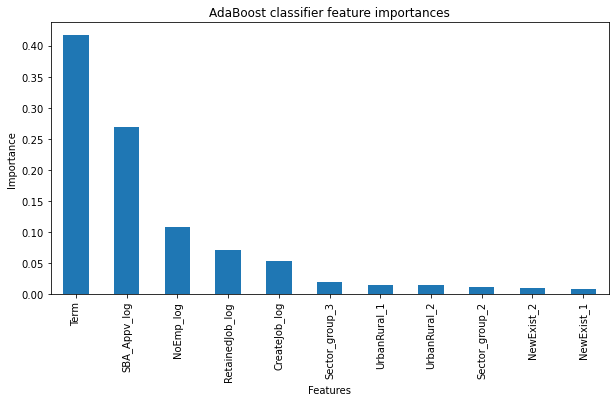

In [103]:
# Plot feature importance
plt.subplots(figsize=(10,5))
abc2_feat_imps = abc2_opt.feature_importances_
abc2_feat_imps = pd.Series(abc2_feat_imps, index=X2_train.columns).sort_values(ascending=False)
abc2_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('AdaBoost classifier feature importances');

As expected, the most important features are "Term" and "SBA_Appv_log". This is consistent with the estimated feature importances for the optimal decision tree classifier and random forest classifier. However, the feature importances decrease much more gradually for all the features after "Term", in contrast to those estimated with previous tree-based models. The feature importances of the other features is also fairly consistent with previous model estimations.

In [349]:
# Save classification report as a dictionary
abc2_report = classification_report(y2_test, abc2_opt.predict(X2_test), 
                                    target_names=None, output_dict=True)

In [291]:
# Save optimized model
abc_model = abc2_opt
abc_model.X_columns = [col for col in X2_train.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'abc_opt_model.pkl'), 'wb') as file:
    pickle.dump(abc_model, file)

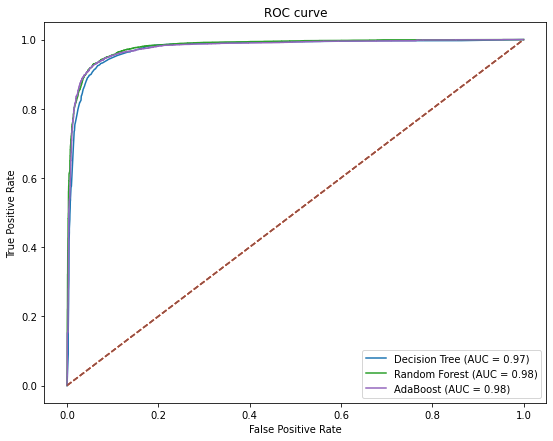

In [285]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers.append(abc2_opt)
list_clfnames.append("AdaBoost")
list_dnames.append("X2_test")
list_dscaled.append(0)

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                               list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

**Summary:** The optimal adaboost classifier for the dataset "X2_train" is "abc2_opt" (n_estimators=100, max_depth=3) with a model accuracy of 93.2%, AUC of 97.6%, and recall scores of 94% and 93% for loans paid in full and loan defaults, respectively.

**Learning curve**

The model performance seems to start to plateau after about 25,000 training examples.

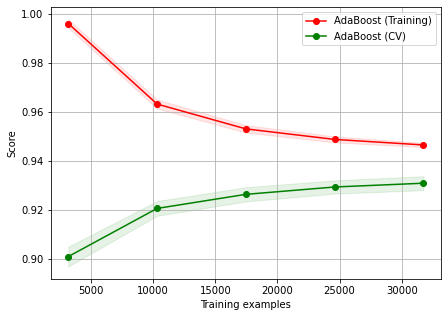

In [106]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = abc2_opt
classifierName = "AdaBoost"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X2_train, y2_train)

**Scale data before model training for machine learning algorithms**

Scaling numerical input features/variables is necessary for better performance when using machine learning algorithms that use a weighted sum of input variables to fit a model, such as linear regression, logistic regression, and artificial neural networks, or algorithms that use distance measures between examples, such as k-nearest neighbours, support vector machines, etc. The two most common types of scaling methods used are: normalization and standardization.

Normalization rescales the numerical input values to a range of values between [0, 1]. This can be achieved via the function "MinMaxScaler" from scikit-learn.

Standardization rescales the values so that the mean of the observed values is 0 and the standard deviation is 1. Therefore, standardization "centers" the data since subtracting the mean from the data is called centering. This method also assumes that the observations fit a Gaussian distribution, and hence should be applied to features that are known to have a Gaussian distribution for reliable results. A dataset can be standardized via the function "StandardScaler" from scikit-learn.

In [107]:
# Display columns of "X_train" training data
X_train.columns

Index(['Term', 'CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log',
       'Sector_11', 'Sector_21', 'Sector_22', 'Sector_23', 'Sector_31',
       'Sector_32', 'Sector_33', 'Sector_42', 'Sector_44', 'Sector_45',
       'Sector_48', 'Sector_49', 'Sector_51', 'Sector_52', 'Sector_53',
       'Sector_54', 'Sector_55', 'Sector_56', 'Sector_61', 'Sector_62',
       'Sector_71', 'Sector_72', 'Sector_81', 'Sector_92', 'NewExist_1',
       'NewExist_2', 'UrbanRural_1', 'UrbanRural_2'],
      dtype='object')

In [108]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define normalization and standardization scalers
norm_scaler = MinMaxScaler()
stand_scaler = StandardScaler()

# Define column indexes for the variables with "normal" and "exponential" distributions
exp_ix = [0, 1, 2, 3]
norm_ix = [4]

# Define the selective transforms
t = [('e', norm_scaler, exp_ix), ('n', stand_scaler, norm_ix)]
selective = ColumnTransformer(transformers=t, remainder='passthrough')

# Scale data
X_train_scaled = pd.DataFrame(selective.fit_transform(X_train))
X_test_scaled = pd.DataFrame(selective.fit_transform(X_test))

In [109]:
# Check scaled values of training data
X_train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
count,39675.000000,39675.000000,39675.000000,39675.000000,3.967500e+04,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,...,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000
mean,0.295823,0.058484,0.124718,0.196096,-1.198173e-15,0.002067,0.000529,0.000529,0.069666,0.019282,...,0.009376,0.050284,0.015551,0.076345,0.080403,0.000101,0.814316,0.185306,0.685343,0.050183
std,0.247073,0.096391,0.119952,0.103921,1.000013e+00,0.045416,0.023001,0.023001,0.254587,0.137515,...,0.096377,0.218532,0.123733,0.265553,0.271920,0.010040,0.388856,0.388550,0.464385,0.218325
min,0.000000,0.000000,0.000000,0.000000,-2.584766e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.131148,0.000000,0.000000,0.119350,-7.473944e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.226776,0.000000,0.120958,0.174845,-4.756672e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.325137,0.120958,0.197273,0.260501,8.150515e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.795159e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
# Check scaled values of testing data
X_test_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
count,9919.000000,9919.000000,9919.000000,9919.000000,9.919000e+03,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,...,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000,9919.000000
mean,0.299912,0.057717,0.124138,0.210283,-1.018643e-15,0.002117,0.000403,0.000504,0.068959,0.018651,...,0.008166,0.050408,0.016736,0.072487,0.078939,0.000302,0.822159,0.177336,0.681419,0.049098
std,0.253051,0.094493,0.118737,0.111383,1.000050e+00,0.045966,0.020078,0.022447,0.253396,0.135296,...,0.090002,0.218797,0.128285,0.259306,0.269658,0.017389,0.382398,0.381972,0.465949,0.216083
min,0.000000,0.000000,0.000000,0.000000,-2.003778e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.128134,0.000000,0.000000,0.126746,-7.369798e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.231198,0.000000,0.120958,0.185679,-5.998748e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.331476,0.120958,0.197273,0.276642,8.071687e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.876460e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
# Display columns of "X2_train" training data
X2_train.columns

Index(['Term', 'CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log',
       'Sector_group_2', 'Sector_group_3', 'NewExist_1', 'NewExist_2',
       'UrbanRural_1', 'UrbanRural_2'],
      dtype='object')

In [112]:
# Define column indexes for the variables with "normal" and "exponential" distributions
exp2_ix = [0, 1, 2, 3]
norm2_ix = [4]

# Define the selective transforms
t2 = [('e', norm_scaler, exp2_ix), ('n', stand_scaler, norm2_ix)]
selective = ColumnTransformer(transformers=t2, remainder='passthrough')

# Scale data
X2_train_scaled = pd.DataFrame(selective.fit_transform(X2_train))
X2_test_scaled = pd.DataFrame(selective.fit_transform(X2_test))

In [113]:
# Check scaled values of training data
X2_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,2.958230e-01,0.247073,0.000000,0.131148,0.226776,0.325137,1.000000
1,39675.0,5.848355e-02,0.096391,0.000000,0.000000,0.000000,0.120958,1.000000
2,39675.0,1.247181e-01,0.119952,0.000000,0.000000,0.120958,0.197273,1.000000
3,39675.0,1.960955e-01,0.103921,0.000000,0.119350,0.174845,0.260501,1.000000
4,39675.0,-1.198173e-15,1.000013,-2.584766,-0.747394,-0.047567,0.815052,2.795159
5,39675.0,1.155135e-01,0.319645,0.000000,0.000000,0.000000,0.000000,1.000000
6,39675.0,7.227221e-01,0.447660,0.000000,0.000000,1.000000,1.000000,1.000000
7,39675.0,8.143163e-01,0.388856,0.000000,1.000000,1.000000,1.000000,1.000000
8,39675.0,1.853056e-01,0.388550,0.000000,0.000000,0.000000,0.000000,1.000000
9,39675.0,6.853434e-01,0.464385,0.000000,0.000000,1.000000,1.000000,1.000000


In [114]:
# Check scaled values of testing data
X2_test_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9919.0,2.999120e-01,0.253051,0.000000,0.128134,0.231198,0.331476,1.00000
1,9919.0,5.771680e-02,0.094493,0.000000,0.000000,0.000000,0.120958,1.00000
2,9919.0,1.241376e-01,0.118737,0.000000,0.000000,0.120958,0.197273,1.00000
3,9919.0,2.102830e-01,0.111383,0.000000,0.126746,0.185679,0.276642,1.00000
4,9919.0,-1.018643e-15,1.000050,-2.003778,-0.736980,-0.059987,0.807169,2.87646
5,9919.0,1.175522e-01,0.322093,0.000000,0.000000,0.000000,0.000000,1.00000
6,9919.0,7.125718e-01,0.452586,0.000000,0.000000,1.000000,1.000000,1.00000
7,9919.0,8.221595e-01,0.382398,0.000000,1.000000,1.000000,1.000000,1.00000
8,9919.0,1.773364e-01,0.381972,0.000000,0.000000,0.000000,0.000000,1.00000
9,9919.0,6.814195e-01,0.465949,0.000000,0.000000,1.000000,1.000000,1.00000


### 6.4 Logistic Regression<a id='6.4_Logistic_Regression'></a>

In [115]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True,
# intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100,
# multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lrc = LogisticRegression(random_state=seed)

**Training data: X_train_scaled**

In [116]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X_train_scaled" training data
verb = 1
lrc_cv_results = crossval(lrc, X_train_scaled, y_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.797, std = 0.003
AUC: mean = 0.891, std = 0.003


In [117]:
# Hyperparameter optimization for logistic regression classifier
# Search for best solver and C value
c_powers = range(-3,4)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': [10**i for i in c_powers]}
lrc_gscv = fit_model(X_train_scaled, y_train, lrc, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
lrc_gscv.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   29.0s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000, random_state=1)

As seen above, the solver "lbfgs" reaches the maximum number of iterations but fails to converge. Since the cross-validation via grid search reveals the solver "lbfgs" to be the optimal solver and a C value that is the maximum value of the range of provided C values, a heatmap of the model accuracy for the different parameter combinations is plotted to have an overview of all the results. This eventually helps in choosing the appropriate optimal parameters.

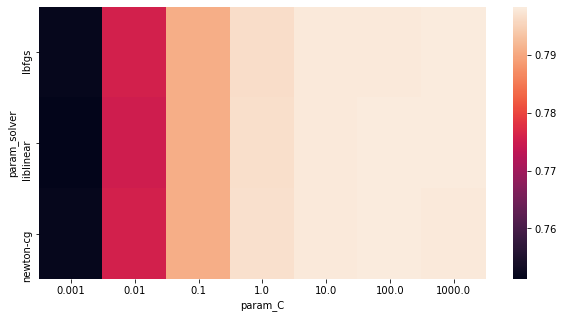

In [118]:
# Plot heatmap to display model performance using different hyperparameter combinations
lrc_gscv_results = pd.DataFrame(lrc_gscv.cv_results_)
lrc_max_scores = lrc_gscv_results.groupby(['param_solver', 'param_C']).max()
lrc_max_scores = lrc_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,5]
sns.heatmap(lrc_max_scores);

In [119]:
# Extract indices for certain C values to check for optimal values
list_C = [10, 100, 1000]
for (index, d) in enumerate(lrc_gscv.cv_results_["params"]):
    for sname in params["solver"]:
        for k in list_C:
            if (d["solver"] == sname) & (d["C"] == k):
                print("Index for solver: %s and C: %.1f = %s" % (sname, k, index))

Index for solver: newton-cg and C: 10.0 = 12
Index for solver: lbfgs and C: 10.0 = 13
Index for solver: liblinear and C: 10.0 = 14
Index for solver: newton-cg and C: 100.0 = 15
Index for solver: lbfgs and C: 100.0 = 16
Index for solver: liblinear and C: 100.0 = 17
Index for solver: newton-cg and C: 1000.0 = 18
Index for solver: lbfgs and C: 1000.0 = 19
Index for solver: liblinear and C: 1000.0 = 20


In [120]:
# Print accuracy scores and AUC for above indices
list_ind = range(12,18)
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in lrc_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in lrc_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.798, 0.7981, 0.798, 0.7981, 0.7981, 0.7981]
AUC: [0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908]


Apparently, there is no significant improvement in the model performance when using a C value of 10 or 100 or 1000. To reduce model complexity and prevent overfitting, a value of 10 is used.

In [121]:
# Search for best solver
lrc1 = LogisticRegression(C=10, random_state=seed)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lrc_gscv = fit_model(X_train_scaled, y_train, lrc1, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
lrc_gscv.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.6s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, random_state=1)

Using C=10 does not allow the solver "lbfgs" to converge since it reaches the maximum number of iterations (a default value of 100).

In [122]:
# Print accuracy scores for all solvers
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in lrc_gscv.cv_results_["mean_test_Accuracy"]]))

Accuracy scores: [0.798, 0.7981, 0.798]


Since the accuracy scores are same for all the solvers, the solver "newton-cg" is used as the optimal solver.

Model accuracy: mean = 0.798, std = 0.003
AUC: mean = 0.891, std = 0.003


              precision    recall  f1-score   support

           0       0.86      0.73      0.79      4913
           1       0.77      0.88      0.82      5006

    accuracy                           0.80      9919
   macro avg       0.81      0.80      0.80      9919
weighted avg       0.81      0.80      0.80      9919



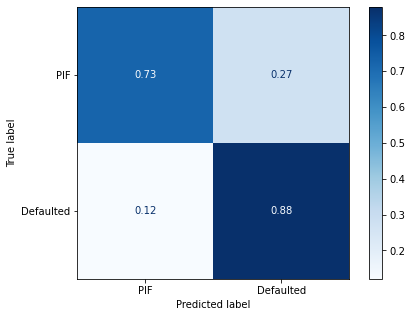

In [123]:
# Cross-validation for optimized model
lrc_ncg = LogisticRegression(C=10, solver="newton-cg", random_state=seed)
lrc_ncg_cv_results = crossval(lrc_ncg, X_train_scaled, y_train, cv, scoring_fnc, n_jobs, verb)
print("\n")

# Fit optimized logistic regression classifier to training data
lrc_ncg.fit(X_train_scaled, y_train)

# Print classification report
print(classification_report(y_test, lrc_ncg.predict(X_test_scaled), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(lrc_ncg, X_test_scaled, y_test, "true")

**Training data: X2_train_scaled**

In [124]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train_scaled" training data
lrc2_cv_results = crossval(lrc, X2_train_scaled, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.795, std = 0.004
AUC: mean = 0.891, std = 0.003


In [125]:
# Hyperparameter optimization for logistic regression classifier
# Search for best solver and C value
c_powers = range(-3,4)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': [10**i for i in c_powers]}
lrc2_gscv = fit_model(X2_train_scaled, y2_train, lrc, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
lrc2_gscv.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   13.3s finished


LogisticRegression(C=10, random_state=1, solver='newton-cg')

Model accuracy: mean = 0.795, std = 0.003
AUC: mean = 0.891, std = 0.003


              precision    recall  f1-score   support

           0       0.85      0.72      0.78      4913
           1       0.76      0.88      0.81      5006

    accuracy                           0.80      9919
   macro avg       0.81      0.80      0.80      9919
weighted avg       0.81      0.80      0.80      9919



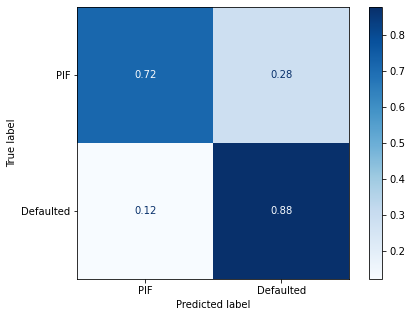

In [126]:
# Fit optimized logistic regression classifier to training data
lrc2_opt = lrc2_gscv.best_estimator_
lrc2_opt.fit(X2_train_scaled, y2_train)

# Cross-validation score for optimized model
lrc2_cv_bestscore = crossvalbestscore(lrc2_gscv)

print("\n")

# Print classification report
print(classification_report(y2_test, lrc2_opt.predict(X2_test_scaled), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(lrc2_opt, X2_test_scaled, y2_test, "true")

The accuracy score for the dataset "X_train_scaled", which includes the feature "Sector" as different categories for each sector, is better by only a value of 0.003 in comparison to the accuracy score for the dataset "X2_train_scaled" (0.795), which combines the different sector categories into groups. Tha AUC score for both the datasets is the same (0.891). Since the model performance for both datasets is very similar, it suggests that combining the information about the feature "Sector" into groups is acceptable. Hence, the dataset "X2_train_scaled" can be used for further analyses, resulting in faster computations given that it has less number of features.

The optimal model for the dataset "X2_train_scaled" is the "lrc2_opt" (best solver: "newton-cg", C value: 10). The accuracy score improves by a small amount of 0.001 after optimization. The recall score is higher for loan defaults, which is good because it is important to correctly classify loans that are actually default loans. This gives confidence in making better predictions for loan defaults.

In [127]:
# Save classification report as a dictionary
lrc2_report = classification_report(y2_test, lrc2_opt.predict(X2_test_scaled),
                                    target_names=None, output_dict=True)

In [292]:
# Save optimized model
lrc2_model = lrc2_opt
lrc2_model.X_columns = [col for col in X2_train_scaled.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'lrc2_opt_model.pkl'), 'wb') as file:
    pickle.dump(lrc2_model, file)

**Normalize features after standardization to have all values between 0 and 1**

Sometimes, having all the numerical input features within the same range improves the performance of a machine learning algorithm. To assess this statement, the following scenarios are tested where the dataset "X2_train_scaled" is normalized (after standardization) to have values within the range [0, 1].

In [129]:
# Check features for normalization
X2_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,2.958230e-01,0.247073,0.000000,0.131148,0.226776,0.325137,1.000000
1,39675.0,5.848355e-02,0.096391,0.000000,0.000000,0.000000,0.120958,1.000000
2,39675.0,1.247181e-01,0.119952,0.000000,0.000000,0.120958,0.197273,1.000000
3,39675.0,1.960955e-01,0.103921,0.000000,0.119350,0.174845,0.260501,1.000000
4,39675.0,-1.198173e-15,1.000013,-2.584766,-0.747394,-0.047567,0.815052,2.795159
5,39675.0,1.155135e-01,0.319645,0.000000,0.000000,0.000000,0.000000,1.000000
6,39675.0,7.227221e-01,0.447660,0.000000,0.000000,1.000000,1.000000,1.000000
7,39675.0,8.143163e-01,0.388856,0.000000,1.000000,1.000000,1.000000,1.000000
8,39675.0,1.853056e-01,0.388550,0.000000,0.000000,0.000000,0.000000,1.000000
9,39675.0,6.853434e-01,0.464385,0.000000,0.000000,1.000000,1.000000,1.000000


In [130]:
# Normalization after standardization to have all values between 0 and 1
# Define the selective transforms
t2_s2 = [('e', norm_scaler, [4])]
selective = ColumnTransformer(transformers=t2_s2, remainder='passthrough')

# Scale data
X2_train_s2 = pd.DataFrame(selective.fit_transform(X2_train_scaled))
X2_test_s2 = pd.DataFrame(selective.fit_transform(X2_test_scaled))

In [131]:
# Check scaled values of training data
X2_train_s2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,0.480446,0.185879,0.0,0.341524,0.471605,0.631945,1.0
1,39675.0,0.295823,0.247073,0.0,0.131148,0.226776,0.325137,1.0
2,39675.0,0.058484,0.096391,0.0,0.000000,0.000000,0.120958,1.0
3,39675.0,0.124718,0.119952,0.0,0.000000,0.120958,0.197273,1.0
4,39675.0,0.196096,0.103921,0.0,0.119350,0.174845,0.260501,1.0
5,39675.0,0.115514,0.319645,0.0,0.000000,0.000000,0.000000,1.0
6,39675.0,0.722722,0.447660,0.0,0.000000,1.000000,1.000000,1.0
7,39675.0,0.814316,0.388856,0.0,1.000000,1.000000,1.000000,1.0
8,39675.0,0.185306,0.388550,0.0,0.000000,0.000000,0.000000,1.0
9,39675.0,0.685343,0.464385,0.0,0.000000,1.000000,1.000000,1.0


In [132]:
# Check scaled values of testing data
X2_test_s2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9919.0,0.410590,0.204918,0.0,0.259577,0.398298,0.575986,1.0
1,9919.0,0.299912,0.253051,0.0,0.128134,0.231198,0.331476,1.0
2,9919.0,0.057717,0.094493,0.0,0.000000,0.000000,0.120958,1.0
3,9919.0,0.124138,0.118737,0.0,0.000000,0.120958,0.197273,1.0
4,9919.0,0.210283,0.111383,0.0,0.126746,0.185679,0.276642,1.0
5,9919.0,0.117552,0.322093,0.0,0.000000,0.000000,0.000000,1.0
6,9919.0,0.712572,0.452586,0.0,0.000000,1.000000,1.000000,1.0
7,9919.0,0.822159,0.382398,0.0,1.000000,1.000000,1.000000,1.0
8,9919.0,0.177336,0.381972,0.0,0.000000,0.000000,0.000000,1.0
9,9919.0,0.681419,0.465949,0.0,0.000000,1.000000,1.000000,1.0


In [133]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train_s2" training data
lrc2_s2_cv_results = crossval(lrc, X2_train_s2, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.795, std = 0.004
AUC: mean = 0.891, std = 0.003


In [134]:
# Hyperparameter optimization for logistic regression classifier
# Search for best solver and C value
c_powers = range(-3,4)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': [10**i for i in c_powers]}
lrc2_s2_gscv = fit_model(X2_train_s2, y2_train, lrc, params, scoring_fnc, refit_fnc,
                         n_jobs, verbosity)
lrc2_s2_gscv.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   11.6s finished


LogisticRegression(C=10, random_state=1, solver='newton-cg')

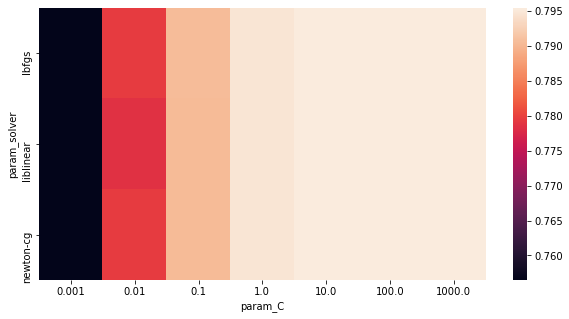

In [135]:
# Plot heatmap to display model performance using different hyperparameter combinations
lrc2_s2_gscv_results = pd.DataFrame(lrc2_s2_gscv.cv_results_)
lrc2_s2_max_scores = lrc2_s2_gscv_results.groupby(['param_solver', 'param_C']).max()
lrc2_s2_max_scores = lrc2_s2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,5]
sns.heatmap(lrc2_s2_max_scores);

The heat map illustrates that the computed optimal value for C is acceptable.

Model accuracy: mean = 0.795, std = 0.003
AUC: mean = 0.891, std = 0.003


              precision    recall  f1-score   support

           0       0.85      0.73      0.78      4913
           1       0.76      0.87      0.81      5006

    accuracy                           0.80      9919
   macro avg       0.81      0.80      0.80      9919
weighted avg       0.81      0.80      0.80      9919



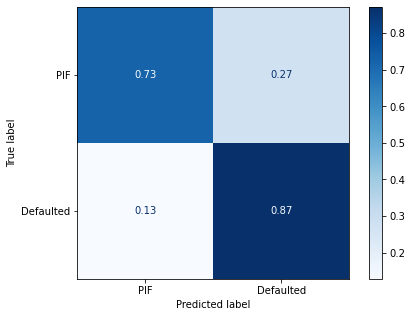

In [136]:
# Cross-validation score for optimized model
lrc2_s2_cv_bestscore = crossvalbestscore(lrc2_s2_gscv)

# Fit optimized logistic regression classifier to training data
lrc2_s2_opt = lrc2_s2_gscv.best_estimator_
lrc2_s2_opt.fit(X2_train_s2, y2_train)

print("\n")

# Print classification report
print(classification_report(y2_test, lrc2_s2_opt.predict(X2_test_s2), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(lrc2_s2_opt, X2_test_s2, y2_test, "true")

The accuracy score is the same as before optimization. Normalizing the data features after standardization does not seem to improve any of the performance metrics. The accuracy score is decreased by a small amount (0.001), so did the recall score (by 0.01), but other metrics have same values as for the dataset that is only standardized.

In [137]:
# Save classification report as a dictionary
lrc2_s2_report = classification_report(y2_test, lrc2_s2_opt.predict(X2_test_s2),
                                       target_names=None, output_dict=True)

In [294]:
# Save optimized model
lrc2_s2_model = lrc2_s2_opt
lrc2_s2_model.X_columns = [col for col in X2_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'lrc2_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(lrc2_s2_model, file)

**Learning curve**

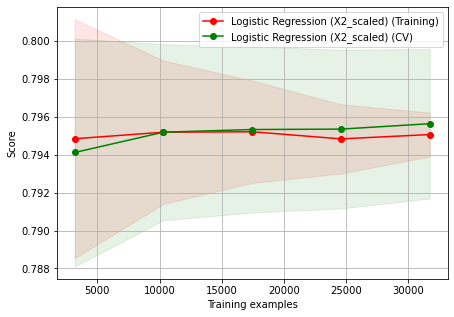

In [173]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = lrc2_opt
classifierName = "Logistic Regression (X2_scaled)"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X2_train_scaled, y2_train)

As seen in the plot above, the model performance does not improve much from more training data after about 10,000 training examples, since both the validation score and the training score converge to a value around 79.5%.

**Generate dataframe including a feature for logarithmic values of "Term"**

Logarithmic scaling is another way to scale numerical input features of a dataset, especially if some of the features have skewed distributions. Since all the features except the feature "Term" have logarithmically scaled values (before applying normalization or standardization), a dataset is generated to include the feature "Term_log", wherein the values of the feature "Term" have been converted to log10 values. This dataset is then used to assess the performance of some of the machine learning algorithms as shown below.

In [142]:
X5_bal_encoded = copy.deepcopy(X2_bal_encoded)
X5_bal_encoded["Term_log"] = np.log10(X5_bal_encoded["Term"])
X5_bal_encoded.drop(["Term"], axis=1, inplace=True)
X5_bal_encoded.columns

Index(['CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log',
       'Sector_group_2', 'Sector_group_3', 'NewExist_1', 'NewExist_2',
       'UrbanRural_1', 'UrbanRural_2', 'Term_log'],
      dtype='object')

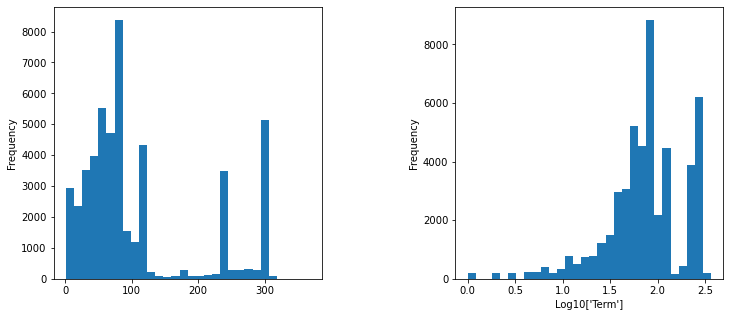

In [144]:
# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
X2_bal_encoded['Term'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of months')
X5_bal_encoded['Term_log'].plot(kind='hist', bins=30, ax=axes[1]).set_xlabel("Log10['Term']")
plt.subplots_adjust(wspace=0.5);

In [145]:
# Split data into training and testing sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X5_bal_encoded, y_bal,
                                                        test_size=tsize, random_state=seed)

# Display columns of data
X5_train.columns

Index(['CreateJob_log', 'RetainedJob_log', 'NoEmp_log', 'SBA_Appv_log',
       'Sector_group_2', 'Sector_group_3', 'NewExist_1', 'NewExist_2',
       'UrbanRural_1', 'UrbanRural_2', 'Term_log'],
      dtype='object')

In [146]:
# Define column indexes for the variables with "normal" and "exponential" distributions
exp5_ix = [0, 1, 2, 10]
norm5_ix = [3]

# Define the selective transforms
t5 = [('e', norm_scaler, exp5_ix), ('n', stand_scaler, norm5_ix)]
selective = ColumnTransformer(transformers=t5, remainder='passthrough')

# Scale data
X5_train_scaled = pd.DataFrame(selective.fit_transform(X5_train))
X5_test_scaled = pd.DataFrame(selective.fit_transform(X5_test))

In [147]:
# Check scaled values of training data
X5_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,5.848355e-02,0.096391,0.000000,0.000000,0.000000,0.120958,1.000000
1,39675.0,1.247181e-01,0.119952,0.000000,0.000000,0.120958,0.197273,1.000000
2,39675.0,1.960955e-01,0.103921,0.000000,0.119350,0.174845,0.260501,1.000000
3,39675.0,7.302682e-01,0.166310,0.000000,0.659032,0.750304,0.810703,1.000000
4,39675.0,-1.198173e-15,1.000013,-2.584766,-0.747394,-0.047567,0.815052,2.795159
5,39675.0,1.155135e-01,0.319645,0.000000,0.000000,0.000000,0.000000,1.000000
6,39675.0,7.227221e-01,0.447660,0.000000,0.000000,1.000000,1.000000,1.000000
7,39675.0,8.143163e-01,0.388856,0.000000,1.000000,1.000000,1.000000,1.000000
8,39675.0,1.853056e-01,0.388550,0.000000,0.000000,0.000000,0.000000,1.000000
9,39675.0,6.853434e-01,0.464385,0.000000,0.000000,1.000000,1.000000,1.000000


In [148]:
# Check scaled values of testing data
X5_test_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9919.0,5.771680e-02,0.094493,0.000000,0.000000,0.000000,0.120958,1.00000
1,9919.0,1.241376e-01,0.118737,0.000000,0.000000,0.120958,0.197273,1.00000
2,9919.0,2.102830e-01,0.111383,0.000000,0.126746,0.185679,0.276642,1.00000
3,9919.0,7.307147e-01,0.167708,0.000000,0.654108,0.752759,0.813355,1.00000
4,9919.0,-1.018643e-15,1.000050,-2.003778,-0.736980,-0.059987,0.807169,2.87646
5,9919.0,1.175522e-01,0.322093,0.000000,0.000000,0.000000,0.000000,1.00000
6,9919.0,7.125718e-01,0.452586,0.000000,0.000000,1.000000,1.000000,1.00000
7,9919.0,8.221595e-01,0.382398,0.000000,1.000000,1.000000,1.000000,1.00000
8,9919.0,1.773364e-01,0.381972,0.000000,0.000000,0.000000,0.000000,1.00000
9,9919.0,6.814195e-01,0.465949,0.000000,0.000000,1.000000,1.000000,1.00000


In [149]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X5_train_scaled" training data
lrc5_cv_results = crossval(lrc, X5_train_scaled, y5_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.804, std = 0.002
AUC: mean = 0.887, std = 0.003


In [150]:
# Hyperparameter optimization for logistic regression classifier
# Search for best solver and C value
c_powers = range(-3,4)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
          'C': [10**i for i in c_powers]}
lrc5_gscv = fit_model(X5_train_scaled, y5_train, lrc, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
lrc5_gscv.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   15.2s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100, random_state=1)

As seen above, the solver "lbfgs" reaches the maximum number of iterations but fails to converge. Since the cross-validation via grid search reveals the solver "lbfgs" to be the optimal solver, a heatmap of the model accuracy for the different parameter combinations is plotted to have an overview of all the results. This eventually helps in choosing the appropriate optimal parameters.

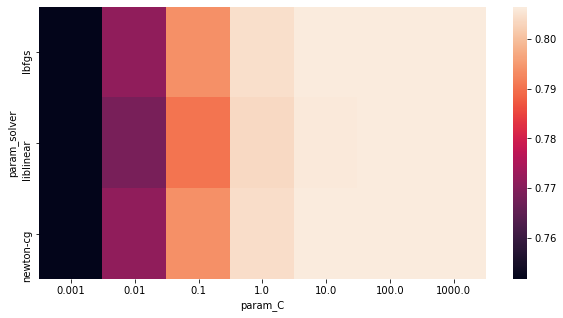

In [151]:
# Plot heatmap to display model performance using different hyperparameter combinations
lrc5_gscv_results = pd.DataFrame(lrc5_gscv.cv_results_)
lrc5_max_scores = lrc5_gscv_results.groupby(['param_solver', 'param_C']).max()
lrc5_max_scores = lrc5_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,5]
sns.heatmap(lrc5_max_scores);

In [152]:
# Extract indices for certain C values to check for optimal values
list_C = [10, 100]
for (index, d) in enumerate(lrc5_gscv.cv_results_["params"]):
    for sname in params["solver"]:
        for k in list_C:
            if (d["solver"] == sname) & (d["C"] == k):
                print("Index for solver: %s and C: %.1f = %s" % (sname, k, index))

Index for solver: newton-cg and C: 10.0 = 12
Index for solver: lbfgs and C: 10.0 = 13
Index for solver: liblinear and C: 10.0 = 14
Index for solver: newton-cg and C: 100.0 = 15
Index for solver: lbfgs and C: 100.0 = 16
Index for solver: liblinear and C: 100.0 = 17


In [153]:
# Print accuracy scores and AUC for above indices
list_ind = range(12,18)
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in lrc5_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in lrc5_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.8063, 0.8063, 0.8062, 0.8064, 0.8064, 0.8064]
AUC: [0.8877, 0.8877, 0.8876, 0.8877, 0.8877, 0.8877]


There is no significant improvement in the model performance when using a C value of 10 or 100. To reduce model complexity and prevent overfitting, a value of 10 is used to then check if the optimal solver is "newton-cg".

In [154]:
# Search for best solver
lrc1 = LogisticRegression(C=10, random_state=seed)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lrc5_gscv = fit_model(X5_train_scaled, y5_train, lrc1, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
lrc5_gscv.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished


LogisticRegression(C=10, random_state=1, solver='newton-cg')

Model accuracy: mean = 0.806, std = 0.003
AUC: mean = 0.888, std = 0.003


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4913
           1       0.80      0.84      0.82      5006

    accuracy                           0.82      9919
   macro avg       0.82      0.82      0.82      9919
weighted avg       0.82      0.82      0.82      9919



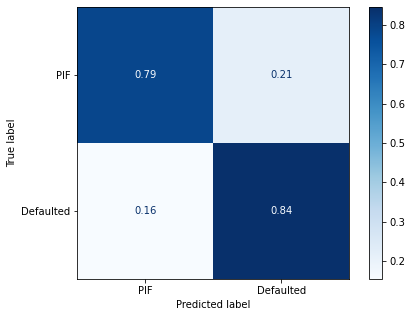

In [155]:
# Cross-validation score for optimized model
lrc5_cv_bestscore = crossvalbestscore(lrc5_gscv)

# Fit optimized logistic regression classifier to training data
lrc5_opt = lrc5_gscv.best_estimator_
lrc5_opt.fit(X5_train_scaled, y5_train)

print("\n")

# Print classification report
print(classification_report(y5_test, lrc5_opt.predict(X5_test_scaled), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(lrc5_opt, X5_test_scaled, y5_test, "true")

The accuracy score improves only by 0.001 after optimization. However, the accuracy score is greater (by 0.01) than for the dataset "X2_scaled_train" (0.796) that does not include logarithmically scaled feature "Term". Also, as seen before, the recall score for loan defaults is higher than for loans paid in full. But it is lower than the recall score for the  the dataset "X2_scaled_train" (0.88). The precision score of loan defaults, on the other hand, is higher for this dataset (0.80) than the dataset "X2_train_scaled" (0.76).

In [156]:
# Save classification report as a dictionary
lrc5_report = classification_report(y5_test, lrc5_opt.predict(X5_test_scaled),
                                    target_names=None, output_dict=True)

In [293]:
# Save optimized model
lrc5_model = lrc5_opt
lrc5_model.X_columns = [col for col in X5_train_scaled.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'lrc5_opt_model.pkl'), 'wb') as file:
    pickle.dump(lrc5_model, file)

**Normalization after standardization**

In [158]:
# Check scaled values of training data
X5_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,5.848355e-02,0.096391,0.000000,0.000000,0.000000,0.120958,1.000000
1,39675.0,1.247181e-01,0.119952,0.000000,0.000000,0.120958,0.197273,1.000000
2,39675.0,1.960955e-01,0.103921,0.000000,0.119350,0.174845,0.260501,1.000000
3,39675.0,7.302682e-01,0.166310,0.000000,0.659032,0.750304,0.810703,1.000000
4,39675.0,-1.198173e-15,1.000013,-2.584766,-0.747394,-0.047567,0.815052,2.795159
5,39675.0,1.155135e-01,0.319645,0.000000,0.000000,0.000000,0.000000,1.000000
6,39675.0,7.227221e-01,0.447660,0.000000,0.000000,1.000000,1.000000,1.000000
7,39675.0,8.143163e-01,0.388856,0.000000,1.000000,1.000000,1.000000,1.000000
8,39675.0,1.853056e-01,0.388550,0.000000,0.000000,0.000000,0.000000,1.000000
9,39675.0,6.853434e-01,0.464385,0.000000,0.000000,1.000000,1.000000,1.000000


In [159]:
# Normalization after standardization to have all values between 0 and 1
# Define the selective transforms
t5_s2 = [('e', norm_scaler, [4])]
selective = ColumnTransformer(transformers=t5_s2, remainder='passthrough')

# Scale data
X5_train_s2 = pd.DataFrame(selective.fit_transform(X5_train_scaled))
X5_test_s2 = pd.DataFrame(selective.fit_transform(X5_test_scaled))

In [160]:
# Check scaled values of training data
X5_train_s2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,39675.0,0.480446,0.185879,0.0,0.341524,0.471605,0.631945,1.0
1,39675.0,0.058484,0.096391,0.0,0.000000,0.000000,0.120958,1.0
2,39675.0,0.124718,0.119952,0.0,0.000000,0.120958,0.197273,1.0
3,39675.0,0.196096,0.103921,0.0,0.119350,0.174845,0.260501,1.0
4,39675.0,0.730268,0.166310,0.0,0.659032,0.750304,0.810703,1.0
5,39675.0,0.115514,0.319645,0.0,0.000000,0.000000,0.000000,1.0
6,39675.0,0.722722,0.447660,0.0,0.000000,1.000000,1.000000,1.0
7,39675.0,0.814316,0.388856,0.0,1.000000,1.000000,1.000000,1.0
8,39675.0,0.185306,0.388550,0.0,0.000000,0.000000,0.000000,1.0
9,39675.0,0.685343,0.464385,0.0,0.000000,1.000000,1.000000,1.0


In [161]:
# Check scaled values of testing data
X5_test_s2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9919.0,0.410590,0.204918,0.0,0.259577,0.398298,0.575986,1.0
1,9919.0,0.057717,0.094493,0.0,0.000000,0.000000,0.120958,1.0
2,9919.0,0.124138,0.118737,0.0,0.000000,0.120958,0.197273,1.0
3,9919.0,0.210283,0.111383,0.0,0.126746,0.185679,0.276642,1.0
4,9919.0,0.730715,0.167708,0.0,0.654108,0.752759,0.813355,1.0
5,9919.0,0.117552,0.322093,0.0,0.000000,0.000000,0.000000,1.0
6,9919.0,0.712572,0.452586,0.0,0.000000,1.000000,1.000000,1.0
7,9919.0,0.822159,0.382398,0.0,1.000000,1.000000,1.000000,1.0
8,9919.0,0.177336,0.381972,0.0,0.000000,0.000000,0.000000,1.0
9,9919.0,0.681419,0.465949,0.0,0.000000,1.000000,1.000000,1.0


In [162]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X5_train_s2" training data
lrc5_s2_cv_results = crossval(lrc, X5_train_s2, y5_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.804, std = 0.002
AUC: mean = 0.887, std = 0.003


In [163]:
# Hyperparameter optimization for logistic regression classifier
# Search for best solver and C value
c_powers = range(-3,4)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
          'C': [10**i for i in c_powers]}
lrc5_s2_gscv = fit_model(X5_train_s2, y5_train, lrc, params, scoring_fnc, refit_fnc,
                         n_jobs, verbosity)
lrc5_s2_gscv.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   16.1s finished


LogisticRegression(C=100, random_state=1, solver='liblinear')

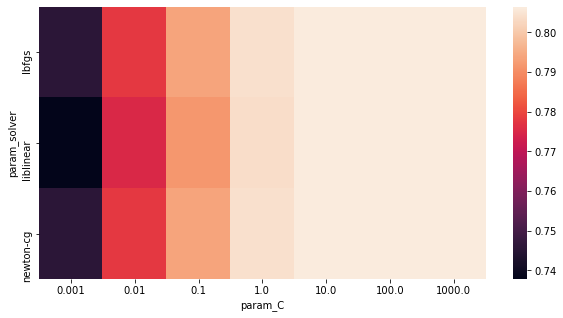

In [164]:
# Plot heatmap to display model performance using different hyperparameter combinations
lrc5_s2_gscv_results = pd.DataFrame(lrc5_s2_gscv.cv_results_)
lrc5_s2_max_scores = lrc5_s2_gscv_results.groupby(['param_solver', 'param_C']).max()
lrc5_s2_max_scores = lrc5_s2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,5]
sns.heatmap(lrc5_s2_max_scores);

In [165]:
# Extract indices for certain C values to check for optimal values
list_C = [10, 100]
for (index, d) in enumerate(lrc5_s2_gscv.cv_results_["params"]):
    for sname in params["solver"]:
        for k in list_C:
            if (d["solver"] == sname) & (d["C"] == k):
                print("Index for solver: %s and C: %.1f = %s" % (sname, k, index))

Index for solver: newton-cg and C: 10.0 = 12
Index for solver: lbfgs and C: 10.0 = 13
Index for solver: liblinear and C: 10.0 = 14
Index for solver: newton-cg and C: 100.0 = 15
Index for solver: lbfgs and C: 100.0 = 16
Index for solver: liblinear and C: 100.0 = 17


In [166]:
# Print accuracy scores and AUC for above indices
list_ind = range(12,18)
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in lrc5_s2_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in lrc5_s2_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.8063, 0.8062, 0.8061, 0.8064, 0.8064, 0.8064]
AUC: [0.8877, 0.8877, 0.8876, 0.8877, 0.8877, 0.8877]


There is no significant improvement in the model performance when using a C-value of 10 vs. 100. To reduce model complexity and prevent overfitting, a value of 10 is then used to search for the optimal solver.

In [167]:
# Search for best solver
lrc1 = LogisticRegression(C=10, random_state=seed)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lrc5_s2_gscv = fit_model(X5_train_s2, y5_train, lrc1, params, scoring_fnc, refit_fnc,
                     n_jobs, verbosity)
lrc5_s2_gscv.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.3s finished


LogisticRegression(C=10, random_state=1, solver='newton-cg')

Model accuracy: mean = 0.806, std = 0.003
AUC: mean = 0.888, std = 0.003


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4913
           1       0.80      0.84      0.82      5006

    accuracy                           0.82      9919
   macro avg       0.82      0.82      0.82      9919
weighted avg       0.82      0.82      0.82      9919



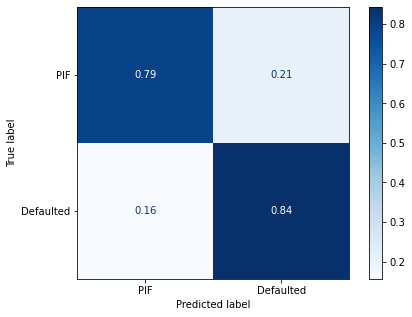

In [168]:
# Cross-validation score for optimized model
lrc5_s2_cv_bestscore = crossvalbestscore(lrc5_s2_gscv)

# Fit optimized logistic regression classifier to training data
lrc5_s2_opt = lrc5_s2_gscv.best_estimator_
lrc5_s2_opt.fit(X5_train_s2, y5_train)

print("\n")

# Print classification report
print(classification_report(y5_test, lrc5_s2_opt.predict(X5_test_s2), target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(lrc5_s2_opt, X5_test_s2, y5_test, "true")

The accuracy score improves only by 0.001 after optimization, and is the same as for the dataset with only standardized features ("X5_train_scaled"). Also, as seen before, the recall score for loan defaults is higher than for loans paid in full but it is lower than the recall score for the dataset "X2_train_s2" (0.87). The precision score of loan defaults, on the other hand, is higher for this dataset (0.80) than the dataset "X2_train_s2" (0.76).

In [169]:
# Save classification report as a dictionary
lrc5_s2_report = classification_report(y5_test, lrc5_s2_opt.predict(X5_test_s2),
                                       target_names=None, output_dict=True)

In [295]:
# Save optimized model
lrc5_s2_model = lrc5_s2_opt
lrc5_s2_model.X_columns = [col for col in X5_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'lrc5_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(lrc5_s2_model, file)

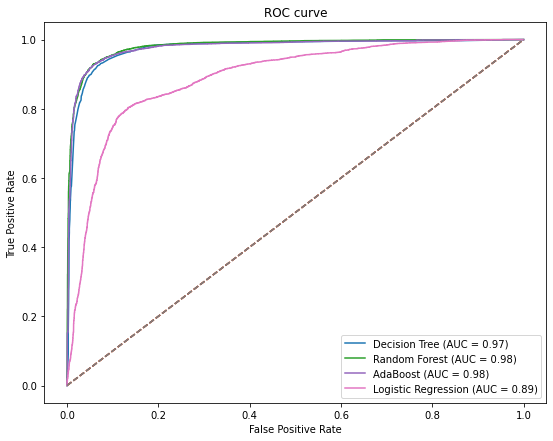

In [286]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers.append(lrc2_opt)
list_clfnames.append("Logistic Regression")
list_dnames.append("X2_test")
list_dscaled.append(1)

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                               list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

In [382]:
# Summarize results for logistic regression classification
list_dataname = ["X2_train_scaled", "X2_train_s2", "X5_train_scaled", "X5_train_s2"]
list_cv_results = [lrc2_cv_results, lrc2_s2_cv_results, lrc5_cv_results, lrc5_s2_cv_results]
list_cv_bestscore = [lrc2_cv_bestscore, lrc2_s2_cv_bestscore, lrc5_cv_bestscore, 
                     lrc5_s2_cv_bestscore]
list_report = [lrc2_report, lrc2_s2_report, lrc5_report, lrc5_s2_report]
df_lrc_col = ["Training data", "Accuracy before opt.", "Accuracy after opt.",
              "Precision", "Recall", "F1-score"]
df_lrc = pd.DataFrame([], columns=df_lrc_col, index=range(len(list_dataname)))
round_num = 3

for ind, dataname, cv_results, cv_bestscore, report \
in zip(df_lrc.index, list_dataname, list_cv_results, list_cv_bestscore, list_report):
    df_lrc.loc[ind,"Training data"] = dataname
    df_lrc.loc[ind,"Accuracy before opt."] = np.round(np.mean(cv_results["test_Accuracy"]), 
                                                      round_num)
    df_lrc.loc[ind,"Accuracy after opt."] = np.round(cv_bestscore[0], round_num)
    df_lrc.loc[ind,"Precision"] = [np.round(report["0"]["precision"], round_num),
                                np.round(report["1"]["precision"], round_num)]
    df_lrc.loc[ind,"Recall"] = [np.round(report["0"]["recall"], round_num),
                                np.round(report["1"]["recall"], round_num)]
    df_lrc.loc[ind,"F1-score"] = [np.round(report["0"]["f1-score"], round_num),
                                np.round(report["1"]["f1-score"], round_num)]
    
df_lrc   

,Training data,Accuracy before opt.,Accuracy after opt.,Precision,Recall,F1-score
0,X2_train_scaled,0.795,0.795,"[0.851, 0.76]","[0.717, 0.877]","[0.779, 0.814]"
1,X2_train_s2,0.795,0.795,"[0.848, 0.764]","[0.726, 0.872]","[0.782, 0.815]"
2,X5_train_scaled,0.804,0.806,"[0.833, 0.801]","[0.786, 0.845]","[0.808, 0.822]"
3,X5_train_s2,0.804,0.806,"[0.832, 0.804]","[0.791, 0.843]","[0.811, 0.823]"


**Summary:** Normalization after standardization does not seem to affect the accuracy scores of the logistic regression models, and only causes small changes in the precision, recall and F1-scores. The optimal logistic regression classifiers for the all the scaled datasets "X2_train_scaled", "X2_train_s2", "X5_train_scaled", and "X5_train_s2" have the optimal C value of 10 and the optimal solver is "newton-cg". The accuracy scores after hyperparameter optimization of all the scaled datasets is similar to their respective accuracy scores before hyperparameter optimization. However, it does seem that converting the values of the feature "Term" to logarithmic values (datasets "X5_train_scaled" and "X5_train_s2") slightly improves the accuracy score by about 0.011.

**Learning curve**

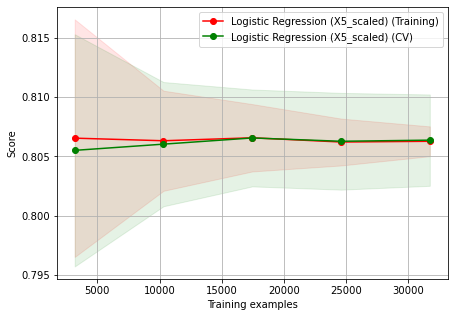

In [177]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = lrc5_opt
classifierName = "Logistic Regression (X5_scaled)"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X5_train_s2, y5_train)

As seen in the plot above, the model performance does not improve much from more training data after about 10,000 training examples, since both the validation score and the training score converge to a value around 80.6%.

### 6.5 K-Nearest Neighbors<a id='6.5_K-Nearest_Neighbors'></a>

In [179]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, 
# p=2, metric='minkowski', metric_params=None, n_jobs=None)
knn = KNeighborsClassifier()

**Training data: X2_train_scaled**

In [180]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train_scaled" training data
cv = 5
verb = 1
knn2_cv_results = crossval(knn, X2_train_scaled, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.852, std = 0.003
AUC: mean = 0.913, std = 0.003


In [181]:
# Hyperparameter optimization for "X2_train_scaled" training data
# Search over a large range of number of neighbours, weights, and power (p)
params = {'n_neighbors': [i for i in range(1, 100, 10)],
          'weights': ['uniform', 'distance'],
          'p': [1, 2]}
knn2_gscv = fit_model(X2_train_scaled, y2_train, knn, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
knn2_gscv.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.9min finished


KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')

In [182]:
# Optimize over a small range of number of neighbours, weights, and power (p)
params = {'n_neighbors': [i for i in range(1, 20)],
          'weights': ['uniform', 'distance'],
          'p': [1, 2]}
knn2_gscv = fit_model(X2_train_scaled, y2_train, knn, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
knn2_gscv.best_estimator_

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:  9.6min finished


KNeighborsClassifier(n_neighbors=15, p=1, weights='distance')

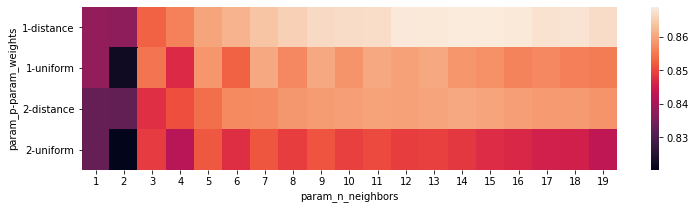

In [183]:
# Plot heatmap to display model performance using different hyperparameter combinations
knn2_gscv_results = pd.DataFrame(knn2_gscv.cv_results_)
knn2_max_scores = knn2_gscv_results.groupby(['param_p', 'param_weights', 
                                             'param_n_neighbors']).max()
knn2_max_scores = knn2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(knn2_max_scores);

The heat map clearly illustrates that using the power parameter p=1 is better than p=2. Furthermore, setting the parameter weights="distance", which weights the points by the inverse of their distance to make predictions so that the closer neighbors of a query point will have a greater influence than neighbors which are further away, is much better than setting it to uniform weights, wherein all points in each neighborhood are weighted equally. However, the model might be overfitting since the accuracy scores seem to plateau for p=1 and weights="distance" around the range of nearest neighbors [11-15]. A detailed analysis of the accuracy scores for these parameters is shown below.

In [184]:
# Extract indices for certain n_neighbors to check for optimal values
list_n_neighbors = [n for n in range(11,16)]
for (index, d) in enumerate(knn2_gscv.cv_results_["params"]):
    for k in list_n_neighbors:
        if (d["n_neighbors"] == k) & (d["p"] == 1) & (d["weights"] == "distance"):
            print('Index for n_neighbors: %s, p: 1, and weights: "distance" = %s' %\
                  (k, index))

Index for n_neighbors: 11, p: 1, and weights: "distance" = 41
Index for n_neighbors: 12, p: 1, and weights: "distance" = 45
Index for n_neighbors: 13, p: 1, and weights: "distance" = 49
Index for n_neighbors: 14, p: 1, and weights: "distance" = 53
Index for n_neighbors: 15, p: 1, and weights: "distance" = 57


In [185]:
# Print accuracy scores and AUC for above indices
list_ind = [41, 45, 49, 53, 57]
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in knn2_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in knn2_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.867, 0.8687, 0.8685, 0.8689, 0.8689]
AUC: [0.9319, 0.9323, 0.9326, 0.9328, 0.9331]


Since there is very little improvement in accuracy score when using number of estimators 12 or more, the value of n_neighbors is set to 12. Moreover, the accuracy score decreases for number of estimators 13 and then increases again for increasing number of estimators, suggesting that the model might be overfitting.

Cross-validation with 12 nearest neighbours:
Model accuracy: mean = 0.869, std = 0.002
AUC: mean = 0.932, std = 0.003


              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4913
           1       0.88      0.84      0.86      5006

    accuracy                           0.86      9919
   macro avg       0.86      0.86      0.86      9919
weighted avg       0.86      0.86      0.86      9919



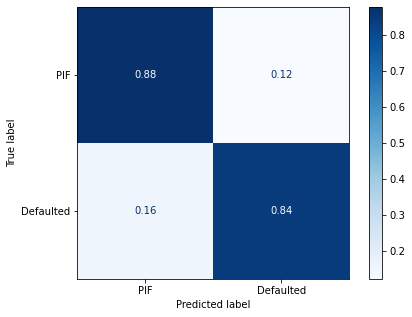

In [187]:
# Cross-validation for model with 12 nearest neighbours
print("Cross-validation with 12 nearest neighbours:")
knn2_opt = KNeighborsClassifier(n_neighbors=12, p=1, weights='distance')
knn2_opt_cv_results = crossval(knn2_opt, X2_train_scaled, y2_train, 
                               cv, scoring_fnc, n_jobs, verb)
knn2_cv_bestscore = [np.mean(knn2_opt_cv_results['test_Accuracy'])]
print("\n")

# Fit optimized K-Nearest Neighbors classifier to training data
knn2_opt.fit(X2_train_scaled, y2_train)

# Print classification report
print(classification_report(y2_test, knn2_opt.predict(X2_test_scaled), target_names=None))

# Plot confusion matrix for test data using the optimized model
plt.rcParams['figure.figsize']=[7,5]
plot_cm(knn2_opt, X2_test_scaled, y2_test, "true")

In [188]:
# Save classification report as a dictionary
knn2_report = classification_report(y2_test, knn2_opt.predict(X2_test_scaled),
                                    target_names=None, output_dict=True)

In [296]:
# Save optimized model
knn2_model = knn2_opt
knn2_model.X_columns = [col for col in X2_train_scaled.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'knn2_opt_model.pkl'), 'wb') as file:
    pickle.dump(knn2_model, file)

**Training data: X2_train_s2**

In [190]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X2_train_s2" training data
knn2_s2_cv_results = crossval(knn, X2_train_s2, y2_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.869, std = 0.001
AUC: mean = 0.923, std = 0.002


As seen above, setting the parameter weights="distance" is much better than setting it to uniform weights. Therefore, the parameter 'weights' is set to use the "distance" metric for all further analyses.

In [191]:
knn = KNeighborsClassifier(weights="distance")

In [192]:
# Hyperparameter optimization for "X2_train_s2" training data
# Search over a large range of number of neighbours, and power (p)
params = {'n_neighbors': [i for i in range(1, 100, 10)],
          'p': [1, 2]}
knn2_s2_gscv = fit_model(X2_train_s2, y2_train, knn, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
knn2_s2_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

In [195]:
# Optimize over a small range of number of neighbours, weights, and power (p)
params = {'n_neighbors': [i for i in range(11, 30)],
          'p': [1, 2]}
knn2_s2_gscv = fit_model(X2_train_s2, y2_train, knn, params, scoring_fnc, refit_fnc, 
                         n_jobs, verbosity)
knn2_s2_gscv.best_estimator_

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.7min finished


KNeighborsClassifier(n_neighbors=14, p=1, weights='distance')

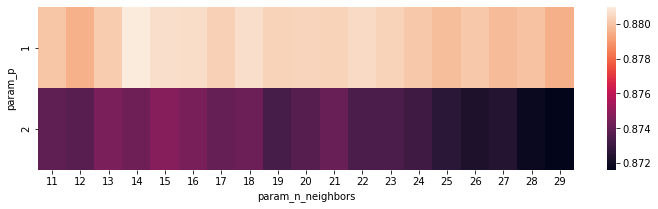

In [196]:
# Plot heatmap to display model performance using different hyperparameter combinations
knn2_s2_gscv_results = pd.DataFrame(knn2_s2_gscv.cv_results_)
knn2_s2_max_scores = knn2_s2_gscv_results.groupby(['param_p', 'param_n_neighbors']).max()
knn2_s2_max_scores = knn2_s2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(knn2_s2_max_scores);

In [197]:
# Extract indices for certain n_neighbors to check for optimal values
list_n_neighbors = [n for n in range (11, 16)] + [21]
for (index, d) in enumerate(knn2_s2_gscv.cv_results_["params"]):
    for k in list_n_neighbors:
        if (d["n_neighbors"] == k) & (d["p"] == 1):
            print("Index for n_neighbors: %s and p: 1 = %s" % (k, index))

Index for n_neighbors: 11 and p: 1 = 0
Index for n_neighbors: 12 and p: 1 = 2
Index for n_neighbors: 13 and p: 1 = 4
Index for n_neighbors: 14 and p: 1 = 6
Index for n_neighbors: 15 and p: 1 = 8
Index for n_neighbors: 21 and p: 1 = 20


In [198]:
# Print accuracy scores and AUC for above indices
list_ind = [n for n in range (0, 9, 2)] + [20]
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in knn2_s2_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in knn2_s2_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.8801, 0.8796, 0.8802, 0.881, 0.8807, 0.8804]
AUC: [0.9388, 0.9392, 0.9396, 0.9399, 0.9401, 0.9407]


Since the accuracy score for the model with 14 nearest neighbors is clearly better than the others, it is chosen as the optimal model for this dataset.

Model accuracy: mean = 0.881, std = 0.003
AUC: mean = 0.940, std = 0.003


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4913
           1       0.89      0.84      0.86      5006

    accuracy                           0.87      9919
   macro avg       0.87      0.87      0.87      9919
weighted avg       0.87      0.87      0.87      9919



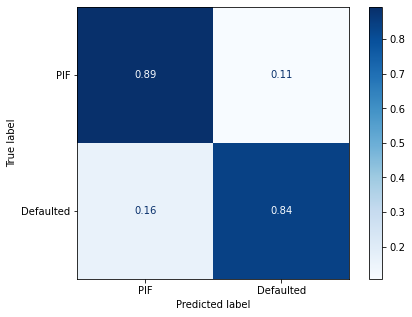

In [199]:
# Cross-validation score for optimized model
knn2_s2_cv_bestscore = crossvalbestscore(knn2_s2_gscv)

# Fit optimized K-Nearest Neighbors classifier to training data
knn2_s2_opt = knn2_s2_gscv.best_estimator_
knn2_s2_opt.fit(X2_train_s2, y2_train)

print("\n")

# Print classification report
print(classification_report(y2_test, knn2_s2_opt.predict(X2_test_s2), target_names=None))

# Plot confusion matrix for test data using the optimized model
plt.rcParams['figure.figsize']=[7,5]
plot_cm(knn2_s2_opt, X2_test_s2, y2_test, "true")

Normalization after standardization does improve the model accuracy for k-nearest neighbors models as opposed to logistic regression models. For k-nearest neighbors, the accuracy score improves by about 0.012 (or 1.2%) for the dataset "X2_train_s2" that is first standardized and then normalized (to have all feature values within the range [0, 1]). The precision score for the loan defaults and the recall score for the loans paid in full have increased by about 0.01 (in comparison with the dataset "X2_train"). This model also has a better score for the AUC (by about 0.8%).

In [200]:
# Save classification report as a dictionary
knn2_s2_report = classification_report(y2_test, knn2_s2_opt.predict(X2_test_s2),
                                       target_names=None, output_dict=True)

In [297]:
# Save optimized model
knn2_s2_model = knn2_s2_opt
knn2_s2_model.X_columns = [col for col in X2_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'knn2_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(knn2_s2_model, file)

**Learning curve**

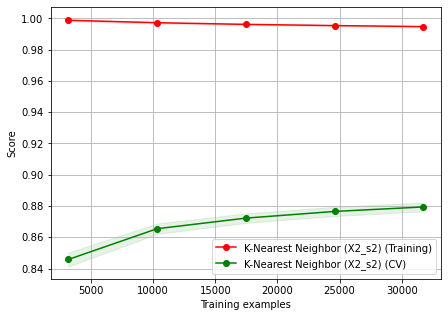

In [203]:
# Set plot parameters
plt.rcParams['figure.figsize']=[7,5]
classifier = knn2_s2_opt
classifierName = "K-Nearest Neighbor (X2_s2)"

# Plot the learning curve
plotlearningcurve(classifier, classifierName, X2_train_s2, y2_train)

As seen in the plot above, the model performance (CV) seems to start to plateau after about 25,000 examples. It is also possible that more training examples are required to improve the perfomance/accuracy score of the model, however, that might be a very small improvement.

**Training data: X5_train_scaled**

In [204]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X5_train_scaled" training data
knn5_cv_results = crossval(knn, X5_train_scaled, y5_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.846, std = 0.002
AUC: mean = 0.910, std = 0.004


In [205]:
# Hyperparameter optimization for "X5_train_scaled" training data
# Search over a large range of number of neighbours, and power (p)
params = {'n_neighbors': [i for i in range(1, 100, 10)],
          'p': [1, 2]}
knn5_gscv = fit_model(X5_train_scaled, y5_train, knn, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
knn5_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

In [206]:
# Optimize over a small range of number of neighbours, and power (p)
params = {'n_neighbors': [i for i in range(11, 30)],
          'p': [1, 2]}
knn5_gscv = fit_model(X5_train_scaled, y5_train, knn, params, scoring_fnc, refit_fnc,
                      n_jobs, verbosity)
knn5_gscv.best_estimator_

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  5.6min finished


KNeighborsClassifier(n_neighbors=18, p=1, weights='distance')

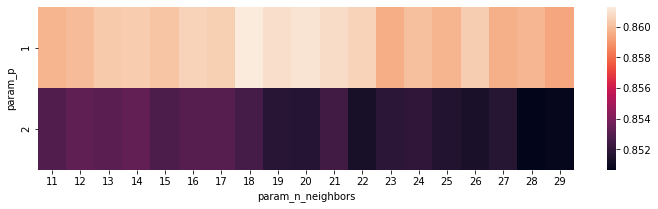

In [207]:
# Plot heatmap to display model performance using different hyperparameter combinations
knn5_gscv_results = pd.DataFrame(knn5_gscv.cv_results_)
knn5_max_scores = knn5_gscv_results.groupby(['param_p', 'param_n_neighbors']).max()
knn5_max_scores = knn5_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(knn5_max_scores);

In [208]:
# Extract indices for certain n_neighbors to check for optimal values
list_n_neighbors = [n for n in range(16,22)]
for (index, d) in enumerate(knn5_gscv.cv_results_["params"]):
    for k in list_n_neighbors:
        if (d["n_neighbors"] == k) & (d["p"] == 1):
            print('Index for n_neighbors: %s and p: 1 = %s' %\
                  (k, index))

Index for n_neighbors: 16 and p: 1 = 10
Index for n_neighbors: 17 and p: 1 = 12
Index for n_neighbors: 18 and p: 1 = 14
Index for n_neighbors: 19 and p: 1 = 16
Index for n_neighbors: 20 and p: 1 = 18
Index for n_neighbors: 21 and p: 1 = 20


In [209]:
# Print accuracy scores and AUC for above indices
list_ind = [n for n in range(10,22,2)]
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in knn5_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in knn5_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.8606, 0.8605, 0.8613, 0.8609, 0.8611, 0.8608]
AUC: [0.9276, 0.9278, 0.9278, 0.9278, 0.9279, 0.9278]


Since the accuracy score for the model with 18 nearest neighbors is clearly better (0.8613) than the others, it is chosen as the optimal model for this dataset.

Model accuracy: mean = 0.861, std = 0.003
AUC: mean = 0.928, std = 0.003


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4913
           1       0.88      0.82      0.85      5006

    accuracy                           0.86      9919
   macro avg       0.86      0.86      0.86      9919
weighted avg       0.86      0.86      0.86      9919



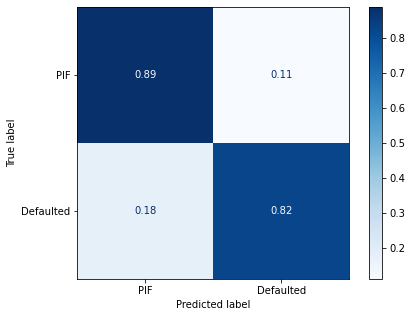

In [210]:
# Cross-validation score for optimized model
knn5_cv_bestscore = crossvalbestscore(knn5_gscv)

# Fit optimized KNN classifier to training data
knn5_opt = knn5_gscv.best_estimator_
knn5_opt.fit(X5_train_scaled, y5_train)

print("\n")

# Print classification report
print(classification_report(y5_test, knn5_opt.predict(X5_test_scaled), target_names=None))

# Plot confusion matrix for test data using the optimized model
plt.rcParams['figure.figsize']=[7,5]
plot_cm(knn5_opt, X5_test_scaled, y5_test, "true")

The accuracy score improves after hyperparameter optimization by an amount of about 0.015. However, the accuracy score for this dataset is less by about 0.008 than the accuracy score for the dataset "X2_train_scaled". It performs slightly better in terms of the recall score for loans paid in full, by about 0.01. But its recall score for loan defaults is less by about 0.02 when compared to the recall score for the dataset "X2_train_scaled".

In [211]:
# Save classification report as a dictionary
knn5_report = classification_report(y5_test, knn5_opt.predict(X5_test_scaled),
                                    target_names=None, output_dict=True)

In [298]:
# Save optimized model
knn5_model = knn5_opt
knn5_model.X_columns = [col for col in X5_train_scaled.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'knn5_opt_model.pkl'), 'wb') as file:
    pickle.dump(knn5_model, file)

**Training data: X5_train_s2**

In [213]:
# Assess performance using cross-validation before hyperparameter optimization
# for "X5_train_s2" training data
knn5_s2_cv_results = crossval(knn, X5_train_s2, y5_train, cv, scoring_fnc, n_jobs, verb)

Model accuracy: mean = 0.862, std = 0.002
AUC: mean = 0.919, std = 0.003


In [214]:
# Hyperparameter optimization for "X5_train_s2" training data
# Search over a large range of number of neighbours, and power (p)
params = {'n_neighbors': [i for i in range(1, 100, 10)],
          'p': [1, 2]}
knn5_s2_gscv = fit_model(X5_train_s2, y5_train, knn, params, scoring_fnc, refit_fnc,
                         n_jobs, verbosity)
knn5_s2_gscv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished


KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

In [215]:
# Optimize over a small range of number of neighbours, and power (p)
params = {'n_neighbors': [i for i in range(11, 30)],
          'p': [1, 2]}
knn5_s2_gscv = fit_model(X5_train_s2, y5_train, knn, params, scoring_fnc, refit_fnc,
                         n_jobs, verbosity)
knn5_s2_gscv.best_estimator_

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  9.8min finished


KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

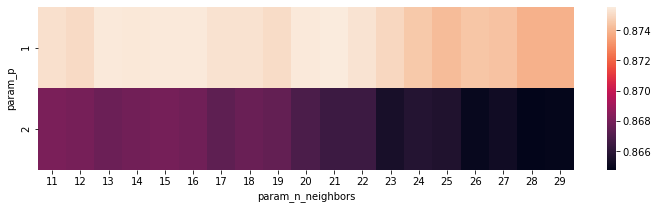

In [216]:
# Plot heatmap to display model performance using different hyperparameter combinations
knn5_s2_gscv_results = pd.DataFrame(knn5_s2_gscv.cv_results_)
knn5_s2_max_scores = knn5_s2_gscv_results.groupby(['param_p', 'param_n_neighbors']).max()
knn5_s2_max_scores = knn5_s2_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[12,3]
sns.heatmap(knn5_s2_max_scores);

In [217]:
# Extract indices for certain n_neighbors to check for optimal values
list_n_neighbors = [n for n in range(13,22)]
for (index, d) in enumerate(knn5_s2_gscv.cv_results_["params"]):
    for k in list_n_neighbors:
        if (d["n_neighbors"] == k) & (d["p"] == 1):
            print('Index for n_neighbors: %s and p: 1 = %s' %\
                  (k, index))

Index for n_neighbors: 13 and p: 1 = 4
Index for n_neighbors: 14 and p: 1 = 6
Index for n_neighbors: 15 and p: 1 = 8
Index for n_neighbors: 16 and p: 1 = 10
Index for n_neighbors: 17 and p: 1 = 12
Index for n_neighbors: 18 and p: 1 = 14
Index for n_neighbors: 19 and p: 1 = 16
Index for n_neighbors: 20 and p: 1 = 18
Index for n_neighbors: 21 and p: 1 = 20


In [218]:
# Print accuracy scores and AUC for above indices
list_ind = [n for n in range(4,21,2)]
print("Accuracy scores: %s" \
      %([np.round(n,4) for n in knn5_s2_gscv.cv_results_["mean_test_Accuracy"][list_ind]]))
print("AUC: %s" \
      %([np.round(n,4) for n in knn5_s2_gscv.cv_results_["mean_test_AUC"][list_ind]]))

Accuracy scores: [0.8755, 0.8754, 0.8755, 0.8755, 0.8753, 0.8753, 0.8751, 0.8755, 0.8755]
AUC: [0.9359, 0.9363, 0.9364, 0.9367, 0.9369, 0.937, 0.937, 0.9371, 0.9371]


The accuracy scores are quite stable for the number of estimators from 13 to 21. This suggests the model might be overfitting after around 13 estimators. Hence, the optimal number of nearest neighbors is chosen to be 13.

Model accuracy: mean = 0.875, std = 0.003
AUC: mean = 0.936, std = 0.003


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4913
           1       0.89      0.83      0.86      5006

    accuracy                           0.86      9919
   macro avg       0.86      0.86      0.86      9919
weighted avg       0.86      0.86      0.86      9919



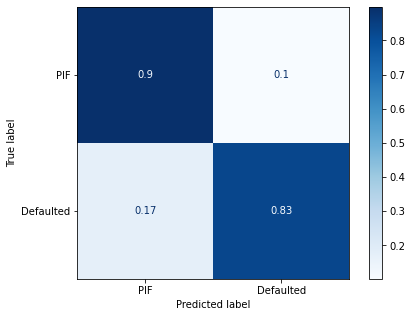

In [219]:
# Cross-validation for optimized model
knn5_s2_opt = KNeighborsClassifier(n_neighbors=13, p=1, weights='distance')
knn5_s2_opt_cv_results = crossval(knn5_s2_opt, X5_train_s2, y5_train, 
                                  cv, scoring_fnc, n_jobs, verb)
knn5_s2_cv_bestscore = [np.mean(knn5_s2_opt_cv_results['test_Accuracy'])]
print("\n")

# Fit optimized K-Nearest Neighbors classifier to training data
knn5_s2_opt.fit(X5_train_s2, y5_train)

# Print classification report
print(classification_report(y5_test, knn5_s2_opt.predict(X5_test_s2), target_names=None))

# Plot confusion matrix for test data using the optimized model
plt.rcParams['figure.figsize']=[7,5]
plot_cm(knn5_s2_opt, X5_test_s2, y5_test, "true")

The accuracy score improves by about 0.013 after hyperparameter optimization. It is also important to note that the accuracy score before optimization is better (by about 0.001) than the best accuracy score for the previous dataset "X5_train_scaled". This suggests that normalization after standardization is beneficial for k-nearest neighbors models. The precision and recall scores for both loan defaults and loans paid in full improve by about 0.1 when compared to the scores for the dataset "X5_train_scaled".

In [220]:
# Save classification report as a dictionary
knn5_s2_report = classification_report(y5_test, knn5_s2_opt.predict(X5_test_s2),
                                       target_names=None, output_dict=True)

In [299]:
# Save optimized model
knn5_s2_model = knn5_s2_opt
knn5_s2_model.X_columns = [col for col in X5_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'knn5_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(knn5_s2_model, file)

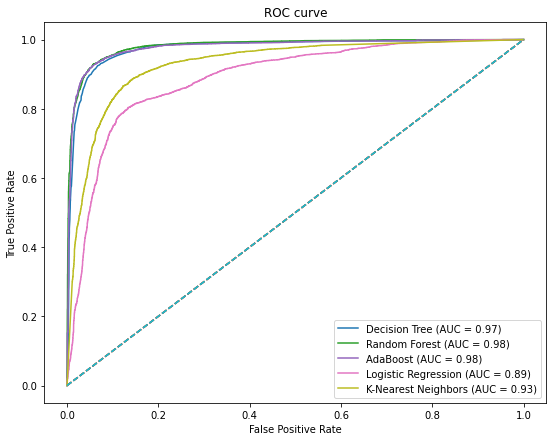

In [287]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers.append(knn2_s2_opt)
list_clfnames.append("K-Nearest Neighbors")
list_dnames.append("X2_test_s2")
list_dscaled.append(2)

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                               list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

In [383]:
# Summarize results for k-nearest neighbour classification
list_dataname = ["X2_train_scaled", "X2_train_s2", "X5_train_scaled", "X5_train_s2"]
list_cv_results = [knn2_cv_results, knn2_s2_cv_results, knn5_cv_results, knn5_s2_cv_results]
list_cv_bestscore = [knn2_cv_bestscore, knn2_s2_cv_bestscore, knn5_cv_bestscore, 
                     knn5_s2_cv_bestscore]
list_report = [knn2_report, knn2_s2_report, knn5_report, knn5_s2_report]
df_knn_col = ["Training data", "Accuracy before opt.", "Accuracy after opt.",
              "Precision", "Recall", "F1-score"]
df_knn = pd.DataFrame([], columns=df_knn_col, index=range(len(list_dataname)))
round_num = 3

for ind, dataname, cv_results, cv_bestscore, report \
in zip(df_knn.index, list_dataname, list_cv_results, list_cv_bestscore, list_report):
    df_knn.loc[ind,"Training data"] = dataname
    df_knn.loc[ind,"Accuracy before opt."] = np.round(np.mean(cv_results["test_Accuracy"]),
                                                      round_num)
    df_knn.loc[ind,"Accuracy after opt."] = np.round(cv_bestscore[0], round_num)
    df_knn.loc[ind,"Precision"] = [np.round(report["0"]["precision"], round_num),
                                np.round(report["1"]["precision"], round_num)]
    df_knn.loc[ind,"Recall"] = [np.round(report["0"]["recall"], round_num),
                                np.round(report["1"]["recall"], round_num)]
    df_knn.loc[ind,"F1-score"] = [np.round(report["0"]["f1-score"], round_num),
                                np.round(report["1"]["f1-score"], round_num)]
    
df_knn

,Training data,Accuracy before opt.,Accuracy after opt.,Precision,Recall,F1-score
0,X2_train_scaled,0.852,0.869,"[0.847, 0.876]","[0.878, 0.844]","[0.862, 0.86]"
1,X2_train_s2,0.869,0.881,"[0.846, 0.889]","[0.893, 0.84]","[0.869, 0.864]"
2,X5_train_scaled,0.846,0.861,"[0.831, 0.882]","[0.888, 0.823]","[0.859, 0.852]"
3,X5_train_s2,0.862,0.875,"[0.836, 0.892]","[0.898, 0.827]","[0.866, 0.858]"


**Summary:** As shown above, normalization after standardization does improve the accuracy of k-nearest neighbors models, along with improvements in the precision, recall and F1-scores. The scores are better when the power parameter (for the Minkowski metric) p = 1, which is equivalent to using manhattan_distance (l1), and when the parameter weights = "distance", which weights the points by the inverse of their distance to make predictions so that the closer neighbors of a query point will have a greater influence than neighbors which are further away.

The optimal KNN classifier for the dataset "X2_train_s2" is "knn2_s2_opt" (n_neighbors=14, p=1, weights="distance") with a model accuracy of 88.1%, and AUC of 94.0%. The optimal KNN classifier for the dataset "X5_train_s2" is "knn5_s2_opt" (n_neighbors=13, p=1, weights="distance") with a model accuracy of 87.5%, and AUC of 93.6%. The above results also suggest that converting the values of the feature "Term" to logarithmic values ("Term_log") does not have much affect on the model's performance since standardizing and normalizing the features of the dataset "X2_train" gives the best results.

### 6.6 Support Vector Machine<a id='6.6_Support_Vector_Machine'></a>

In [226]:
from sklearn.svm import SVC

# SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True,
# probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False,
# max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
svm = SVC(random_state=seed)

Since support vector machines are compuationally very intensive, the parameter optimization for some hyperparameters is done separately.

Optimization to search for best kernel:

In [228]:
# Hyperparameter optimization for all 4 training datasets

# Search for best kernel
params = [{'kernel': ['linear']}, {'kernel': ['poly'], 'degree': [2, 3]}, 
          {'kernel': ['rbf']}, {'kernel': ['sigmoid']}]
list_Xtrain_name = ["X2_train_scaled", "X2_train_s2", "X5_train_scaled", "X5_train_s2"]
list_Xtrain_data = [X2_train_scaled, X2_train_s2, X5_train_scaled, X5_train_s2]
svm_ker_gscv_results = []

for dataname, Xtraindata in zip(list_Xtrain_name, list_Xtrain_data):
    
    # Use "y2_train" for X2 datasets
    if "X5" not in dataname:
        y_train = y2_train
    else:
        y_train = y5_train    
    
    # Fit model via GridSearchCV
    svm_ker_gscv = fit_model(np.ascontiguousarray(Xtraindata.to_numpy()), y_train, 
                             svm, params, scoring_fnc, refit_fnc, n_jobs, verbosity)
    
    # Append results
    svm_ker_gscv_results.append(svm_ker_gscv.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 11.2min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 11.8min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.6min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 10.2min finished


In [232]:
# Display results sorted by "mean_test_Accuracy"
svm_ker_gscv_results_listdf = []
for result in svm_ker_gscv_results:
    results_df = pd.DataFrame(result)
    results_df = results_df.sort_values(by=['rank_test_Accuracy'])
    results_df = (results_df.set_index(results_df["params"].apply(
                  lambda x: "_".join(str(val) for val in x.values()))).rename_axis('kernel'))
    svm_ker_gscv_results_listdf.append(results_df)
    
# Create one dataframe for all results
svm_ker_gscv_results_df = pd.concat({"X2_train_scaled": svm_ker_gscv_results_listdf[0], 
                                     "X2_train_s2": svm_ker_gscv_results_listdf[1],
                                     "X5_train_scaled": svm_ker_gscv_results_listdf[2],
                                     "X5_train_s2": svm_ker_gscv_results_listdf[3]},
                                    names=['Training data'])
svm_ker_gscv_results_df[['mean_test_Accuracy', 'std_test_Accuracy']].round(4)

mean_test_Accuracy  std_test_Accuracy
Training data   kernel                                        
X2_train_scaled 3_poly               0.8542             0.0030
                2_poly               0.8525             0.0013
                rbf                  0.8510             0.0017
                linear               0.7919             0.0035
                sigmoid              0.6003             0.0174
X2_train_s2     3_poly               0.8527             0.0019
                rbf                  0.8455             0.0031
                2_poly               0.8096             0.0028
                linear               0.7919             0.0036
                sigmoid              0.6019             0.0050
X5_train_scaled 3_poly               0.8500             0.0015
                2_poly               0.8447             0.0015
                rbf                  0.8183             0.0016
                linear               0.7930             0.0038
                sigmoid              0.6046             0.0156
X5_train_s2     3_poly               0.8527             0.0020
                rbf                  0.8128             0.0050
                2_poly               0.8083             0.0040
                linear               0.7930             0.0039
                sigmoid              0.5935             0.0050

As seen above, the datasets "X2_train_scaled" and "X2_train_s2" have comparabale accuracy scores for the optimal kernel - a polynomial with degree 3. This is also true for the datasets "X5_train_scaled" and "X5_train_s2". Since support vector machines are compuationally very intensive, the datasets "X2_train_s2" and "X5_train_s2" are chosen for further analyses.

Although, the number of hyperparameters, which influences the complexity of a model, is less for the RBF kernel than the polynomial kernel, the latter is chosen since it has better accuracy scores.

Optimization to search for optimal degree of polynomial kernel:

In [233]:
# Search for optimal degree of polynomial kernel
svm = SVC(kernel='poly', coef0=1, random_state=seed)
params = {'degree': [n for n in range(2,7)]}
list_Xtrain_name = ["X2_train_s2", "X5_train_s2"]
list_Xtrain_data = [X2_train_s2, X5_train_s2]
svm_deg_gscv_results = []

for dataname, Xtraindata in zip(list_Xtrain_name, list_Xtrain_data):
    
    # Use "y2_train" for X2 datasets
    if "X5" not in dataname:
        y_train = y2_train
    else:
        y_train = y5_train    
   
    # Fit model via GridSearchCV
    svm_deg_gscv = fit_model(np.ascontiguousarray(Xtraindata.to_numpy()), y_train, 
                             svm, params, scoring_fnc, refit_fnc, n_jobs, verbosity)
    
    # Append results
    svm_deg_gscv_results.append(svm_deg_gscv.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 10.3min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.8min finished


In [234]:
# Display results sorted by "mean_test_Accuracy"
svm_deg_gscv_results_listdf = []
for result in svm_deg_gscv_results:
    results_df = pd.DataFrame(result).sort_values(by=['rank_test_Accuracy'])
    results_df = (results_df.set_index(results_df["params"].apply(
                  lambda x: "_".join(str(val) for val in x.values()))).rename_axis('degree'))
    svm_deg_gscv_results_listdf.append(results_df)
    
# Create one dataframe for all results
svm_deg_gscv_results_df = pd.concat({"X2_train_s2": svm_deg_gscv_results_listdf[0], 
                                     "X5_train_s2": svm_deg_gscv_results_listdf[1]},
                                    names=['Training data'])
svm_deg_gscv_results_df[['mean_test_Accuracy', 'std_test_Accuracy']].round(4)

mean_test_Accuracy  std_test_Accuracy
Training data degree                                       
X2_train_s2   6                   0.8611             0.0023
              5                   0.8586             0.0025
              4                   0.8583             0.0022
              3                   0.8582             0.0011
              2                   0.8323             0.0039
X5_train_s2   3                   0.8585             0.0019
              6                   0.8580             0.0022
              5                   0.8567             0.0015
              4                   0.8549             0.0018
              2                   0.8171             0.0050

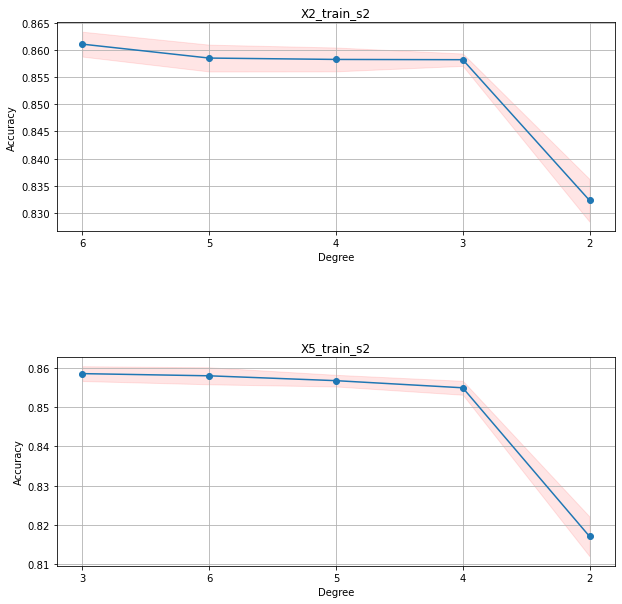

In [236]:
# Plot scores with standard deviations for different degrees
fig, axes = plt.subplots(nrows=2, ncols=1)
plt.rcParams['figure.figsize']=[10,10]

for dataname, k in zip(list_Xtrain_name, [n for n in range(2)]):
    ndeg = svm_deg_gscv_results_df.loc[dataname].index
    train_scores_mean = svm_deg_gscv_results_df.loc[dataname]["mean_test_Accuracy"]
    train_scores_std = svm_deg_gscv_results_df.loc[dataname]["std_test_Accuracy"]
    axes[k].plot(ndeg, train_scores_mean, 'o-')
    axes[k].grid()
    axes[k].fill_between(ndeg, train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[k].set_xlabel("Degree")
    axes[k].set_ylabel("Accuracy")
    axes[k].set_title(dataname);
    plt.subplots_adjust(hspace=0.6);

For the dataset "X2_train_s2", there is very little improvement in model accuracy for a polynomial of degree 3 to 6 (about 0.0029). To reduce model complexity and prevent overfitting, the optimal degree is chosen to be 3. This degree value is also optimal for the dataset "X5_train_s2".

Moreover, there might be more numerical difficulties for polynomial kernels of which kernel values may go to infinity ($γx_i^Tx_j + r > 1$) or zero ($γx_i^Tx_j + r < 1$) while the degree is large.

In [237]:
# Assess performance using cross-validation for "X2_train_s2" training data,
# before hyperparameter optimization of C and gamma values
verb = 1
svm_s2 = SVC(kernel='poly', degree=3, coef0=1, random_state=seed)
start = time.time()
svm2_s2_cv = crossval(svm_s2, np.ascontiguousarray(X2_train_s2.to_numpy()), y2_train, 
                      cv, scoring_fnc, n_jobs, verb)
print(f"Computation time: {format(time.time() - start, '.2f')} s")

Model accuracy: mean = 0.858, std = 0.001
AUC: mean = 0.900, std = 0.003
Computation time: 112.47 s


In [238]:
# Compute variance of dataset (value used as gamma="scale")
print("The 'scale' gamma value is: %s" %(X2_train_s2.to_numpy().var()))

The 'scale' gamma value is: 0.1650115423867229


In [239]:
# Search over a range of C and gamma values
c_powers = range(-2,3)
gamma_powers = range(-3,1)
params = {'C': [10**i for i in c_powers], 
          'gamma': [10**i for i in gamma_powers] + ['scale']}
svm2_s2_gscv = fit_model(np.ascontiguousarray(X2_train_s2.to_numpy()), y2_train, 
                         svm_s2, params, scoring_fnc, refit_fnc, n_jobs, verbosity)
svm2_s2_gscv.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 54.9min finished


SVC(C=100, coef0=1, gamma=1, kernel='poly', random_state=1)

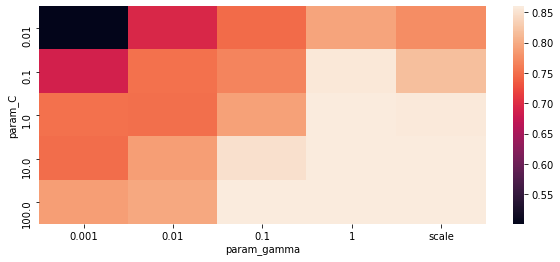

In [240]:
# Plot heatmap to display model performance using different hyperparameter combinations
svm2_s2_gscv_results = pd.DataFrame(svm2_s2_gscv.cv_results_)
svm2_s2_gscv_max_scores = svm2_s2_gscv_results.groupby(['param_C', 'param_gamma']).max()
svm2_s2_gscv_max_scores = svm2_s2_gscv_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,4]
sns.heatmap(svm2_s2_gscv_max_scores);

In [241]:
# Print accuracy scores for some indices
svm2_s2_gscv_max_scores.loc[1:100, [1,'scale']]

param_gamma,1,scale
param_C,,
1.0,0.858500,0.858248
10.0,0.859357,0.859105
100.0,0.859735,0.859584


The accuracy scores are quite stable for the C values of 1, 10, and 100, and gamma values of "scale" (about 0.165) and 1. To reduce model complexity and prevent overfitting, a C value of 10 and gamma value of "scale" is chosen. 

As mentioned previously, polynomial kernels can have numerical difficulties when the kernel 
values may go to infinity ($γx_i^Tx_j + r > 1$) or zero ($γx_i^Tx_j + r < 1$) while the degree is large. Therefore, as the C and gamma values increase, the computation time also increases significantly (). Although it might seem that the accuracy scores could improve with larger C and gamma values for the given problem, these values are not tested because of the significant increase in computation time.

A quick look at the precision and recall scores for the C and gamma values of (100, 1) and (10, 1) suggest that the chosen values of (10, "scale") would suffice.

Model accuracy: mean = 0.860, std = 0.003
AUC: mean = 0.902, std = 0.002


              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4913
           1       0.89      0.80      0.84      5006

    accuracy                           0.85      9919
   macro avg       0.85      0.85      0.85      9919
weighted avg       0.85      0.85      0.85      9919



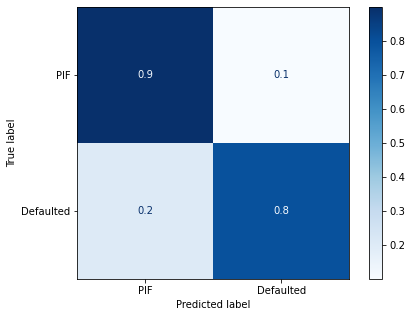

In [242]:
# Cross-validation score for optimized model
svm2_s2_cv_bestscore = crossvalbestscore(svm2_s2_gscv)
print("\n")

# Fit optimized SVM classifier to training data
svm2_s2_tmp1 = svm2_s2_gscv.best_estimator_
svm2_s2_tmp1.fit(np.ascontiguousarray(X2_train_s2.to_numpy()), y2_train)

# Print classification report
print(classification_report(y2_test, 
                            svm2_s2_tmp1.predict(np.ascontiguousarray(X2_test_s2.to_numpy())), 
                            target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(svm2_s2_tmp1, np.ascontiguousarray(X2_test_s2.to_numpy()), y2_test, "true")

In [243]:
# Extract indices for certain C and gamma values
list_c_val = [10]
list_g_val = ["scale", 1]
for (index, d) in enumerate(svm2_s2_gscv.cv_results_["params"]):
    for k in list_c_val:
        for i in list_g_val:
            if (d["C"] == k) & (d["gamma"] == i):
                print('Index for C: %s and gamma: %s = %s' %(k, i, index))

Index for C: 10 and gamma: 1 = 18
Index for C: 10 and gamma: scale = 19


Model accuracy: mean = 0.859, std = 0.003
AUC: mean = 0.901, std = 0.002


              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4913
           1       0.89      0.80      0.84      5006

    accuracy                           0.85      9919
   macro avg       0.85      0.85      0.85      9919
weighted avg       0.85      0.85      0.85      9919



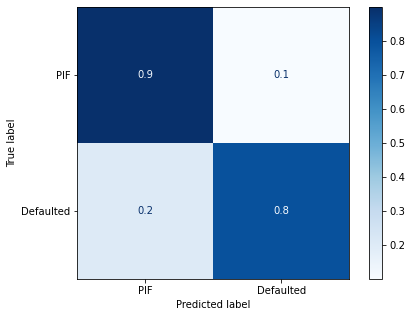

In [244]:
# Cross-validation score for optimized model
svm2_s2_tmp2 = SVC(kernel='poly', degree=3, coef0=1, C=10, gamma=1, random_state=seed)
print("Model accuracy: mean = %.3f," %(svm2_s2_gscv.cv_results_["mean_test_Accuracy"][18]), 
      "std = %.3f" %(svm2_s2_gscv.cv_results_["std_test_Accuracy"][18]))
print("AUC: mean = %.3f," %(svm2_s2_gscv.cv_results_["mean_test_AUC"][18]), 
      "std = %.3f" %(svm2_s2_gscv.cv_results_["std_test_AUC"][18]))
print("\n")

# Fit optimized SVM classifier to training data
svm2_s2_tmp2.fit(np.ascontiguousarray(X2_train_s2.to_numpy()), y2_train)

# Print classification report
print(classification_report(y2_test, 
                            svm2_s2_tmp2.predict(np.ascontiguousarray(X2_test_s2.to_numpy())),
                            target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(svm2_s2_tmp2, np.ascontiguousarray(X2_test_s2.to_numpy()), y2_test, "true")

Model accuracy: mean = 0.859, std = 0.002
AUC: mean = 0.900, std = 0.003


              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4913
           1       0.89      0.80      0.84      5006

    accuracy                           0.85      9919
   macro avg       0.85      0.85      0.85      9919
weighted avg       0.85      0.85      0.85      9919



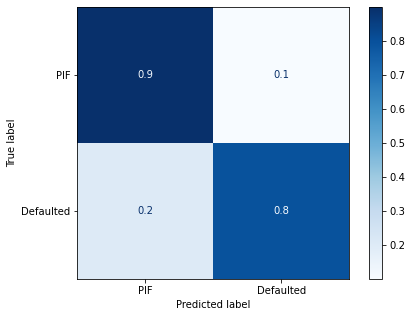

In [245]:
# Cross-validation score for optimized model
svm2_s2_tmp3 = SVC(kernel='poly', degree=3, coef0=1, C=10, gamma="scale", random_state=seed)
print("Model accuracy: mean = %.3f," %(svm2_s2_gscv.cv_results_["mean_test_Accuracy"][19]), 
      "std = %.3f" %(svm2_s2_gscv.cv_results_["std_test_Accuracy"][19]))
print("AUC: mean = %.3f," %(svm2_s2_gscv.cv_results_["mean_test_AUC"][19]), 
      "std = %.3f" %(svm2_s2_gscv.cv_results_["std_test_AUC"][19]))
print("\n")

# Fit optimized SVM classifier to training data
svm2_s2_tmp3.fit(np.ascontiguousarray(X2_train_s2.to_numpy()), y2_train)

# Print classification report
print(classification_report(y2_test, 
                            svm2_s2_tmp3.predict(np.ascontiguousarray(X2_test_s2.to_numpy())),
                            target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(svm2_s2_tmp3, np.ascontiguousarray(X2_test_s2.to_numpy()), y2_test, "true")

In [246]:
# Optimized model
svm2_s2_opt = svm2_s2_tmp3
svm2_s2_cv_bestscore = svm2_s2_gscv_max_scores.loc[10, "scale"]

In [300]:
# Save optimized model
svm2_s2_model = svm2_s2_opt
svm2_s2_model.X_columns = [col for col in X2_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'svm2_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(svm2_s2_model, file)

In [248]:
# Save classification report as a dictionary
svm2_s2_report = classification_report(y2_test, 
                                       svm2_s2_opt.predict(np.ascontiguousarray(
                                           X2_test_s2.to_numpy())), 
                                       target_names=None, output_dict=True)

**Training data: "X5_train_s2"**

In [249]:
# Assess performance using cross-validation for "X5_train_s2" training data,
# before hyperparameter optimization of C and gamma values
svm_s2 = SVC(kernel='poly', degree=3, coef0=1, random_state=seed)
start = time.time()
svm5_s2_cv = crossval(svm_s2, np.ascontiguousarray(X5_train_s2.to_numpy()), y5_train, 
                      cv, scoring_fnc, n_jobs, verb)
print(f"Computation time: {format(time.time() - start, '.2f')} s")

Model accuracy: mean = 0.859, std = 0.002
AUC: mean = 0.904, std = 0.002
Computation time: 105.80 s


In [250]:
# Compute variance of dataset (value used as gamma="scale")
X5_train_s2.to_numpy().var()

0.1741648860557114

In [253]:
# Search over a range for C and gamma values
c_powers = range(-2,3)
gamma_powers = range(-3,1)
params = {'C': [10**i for i in c_powers], 
          'gamma': [10**i for i in gamma_powers] + ['scale']}
svm5_s2_gscv = fit_model(np.ascontiguousarray(X5_train_s2.to_numpy()), y5_train, 
                         svm_s2, params, scoring_fnc, refit_fnc, n_jobs, verbosity)
svm5_s2_gscv.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 66.8min finished


SVC(C=100, coef0=1, gamma=0.1, kernel='poly', random_state=1)

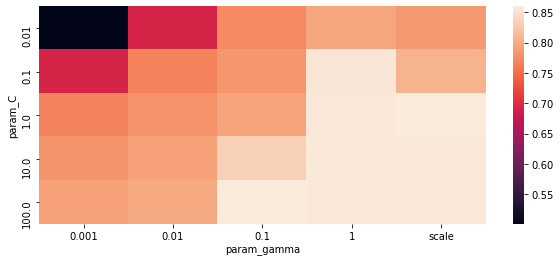

In [254]:
# Plot heatmap to display model performance using different hyperparameter combinations
svm5_s2_gscv_results = pd.DataFrame(svm5_s2_gscv.cv_results_)
svm5_s2_gscv_max_scores = svm5_s2_gscv_results.groupby(['param_C', 'param_gamma']).max()
svm5_s2_gscv_max_scores = svm5_s2_gscv_max_scores.unstack()['mean_test_Accuracy']
plt.rcParams['figure.figsize']=[10,4]
sns.heatmap(svm5_s2_gscv_max_scores);

In [255]:
# Print accuracy scores for some indices
svm5_s2_gscv_max_scores.loc[1:100, [0.1, 1,'scale']]

param_gamma,0.1,1,scale
param_C,,,
1.0,0.794732,0.856181,0.858526
10.0,0.833699,0.856686,0.856282
100.0,0.859761,0.858198,0.856912


The accuracy scores are quite stable for the C values of 1, 10, and 100, and gamma values of "scale" (about 0.174) and 1. The optimal C and gamma values estimated via cross-validation by grid search are 100 and 0.1, respectively. However, a C value of 100 might be a case where the model is overfitting, since using a large C value allows for less misclassification of the instances resulting in a model that might not generalize well. The second best C and gamma value combination is (1, "scale"). To reduce any numerical difficulties, model complexity, and prevent overfitting, a C value of 1 and gamma value of "scale" is chosen. 

A quick look at the precision and recall scores for the C and gamma values of (100, 0.1) suggest that the chosen values of (1, "scale") would suffice.

Model accuracy: mean = 0.860, std = 0.002
AUC: mean = 0.905, std = 0.002


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4913
           1       0.89      0.80      0.85      5006

    accuracy                           0.85      9919
   macro avg       0.86      0.85      0.85      9919
weighted avg       0.86      0.85      0.85      9919



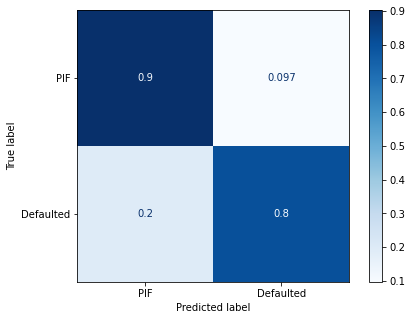

In [256]:
# Cross-validation score for optimized model
svm5_s2_cv_bestscore = crossvalbestscore(svm5_s2_gscv)
print("\n")

# Fit optimized SVM classifier to training data
svm5_s2_tmp1 = svm5_s2_gscv.best_estimator_
svm5_s2_tmp1.fit(np.ascontiguousarray(X5_train_s2.to_numpy()), y5_train)

# Print classification report
print(classification_report(y5_test, 
                            svm5_s2_tmp1.predict(np.ascontiguousarray(X5_test_s2.to_numpy())), 
                            target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(svm5_s2_tmp1, np.ascontiguousarray(X5_test_s2.to_numpy()), y5_test, "true")

In [257]:
# Extract indices for C=1 and gamma="scale"
c_val = 1
g_val = "scale"
for (index, d) in enumerate(svm5_s2_gscv.cv_results_["params"]):
    if (d["C"] == c_val) & (d["gamma"] == g_val):
        print('Index for C: %s and gamma: %s = %s' %(c_val, g_val, index))

Index for C: 1 and gamma: scale = 14


Model accuracy: mean = 0.859, std = 0.002
AUC: mean = 0.904, std = 0.002


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4913
           1       0.89      0.80      0.84      5006

    accuracy                           0.85      9919
   macro avg       0.85      0.85      0.85      9919
weighted avg       0.85      0.85      0.85      9919



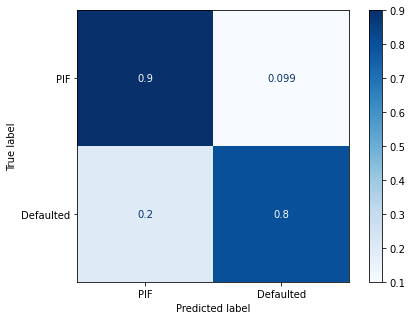

In [258]:
# Cross-validation score for optimized model
svm5_s2_tmp2 = SVC(kernel='poly', degree=3, coef0=1, C=1, gamma="scale", random_state=seed)
print("Model accuracy: mean = %.3f," %(svm5_s2_gscv.cv_results_["mean_test_Accuracy"][14]), 
      "std = %.3f" %(svm5_s2_gscv.cv_results_["std_test_Accuracy"][14]))
print("AUC: mean = %.3f," %(svm5_s2_gscv.cv_results_["mean_test_AUC"][14]), 
      "std = %.3f" %(svm5_s2_gscv.cv_results_["std_test_AUC"][14]))
print("\n")

# Fit optimized SVM classifier to training data
svm5_s2_tmp2.fit(np.ascontiguousarray(X5_train_s2.to_numpy()), y5_train)

# Print classification report
print(classification_report(y5_test, 
                            svm5_s2_tmp2.predict(np.ascontiguousarray(X5_test_s2.to_numpy())),
                            target_names=None))

# Plot confusion matrix for test data
plt.rcParams['figure.figsize']=[7,5]
plot_cm(svm5_s2_tmp2, np.ascontiguousarray(X5_test_s2.to_numpy()), y5_test, "true")

In [259]:
# Optimized model
svm5_s2_opt = svm5_s2_tmp2
svm5_s2_cv_bestscore = svm5_s2_gscv_max_scores.loc[1, "scale"]

In [260]:
# Save classification report as a dictionary
svm5_s2_report = classification_report(y5_test, 
                                       svm5_s2_opt.predict(np.ascontiguousarray(
                                           X5_test_s2.to_numpy())), 
                                       target_names=None, output_dict=True)

In [301]:
# Save optimized model
svm5_s2_model = svm5_s2_opt
svm5_s2_model.X_columns = [col for col in X5_train_s2.columns]

modelpath = '../data_models/models'
with open(os.path.join(modelpath, 'svm5_s2_opt_model.pkl'), 'wb') as file:
    pickle.dump(svm5_s2_model, file)

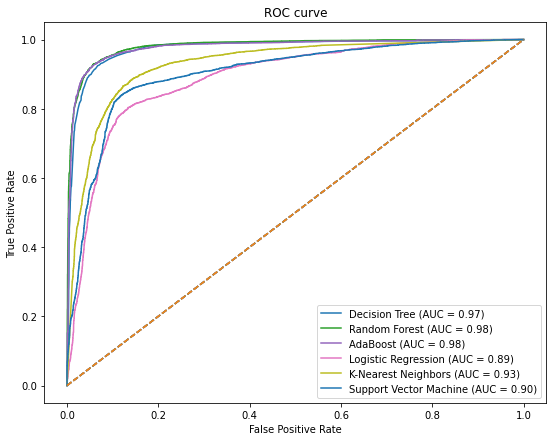

In [288]:
# Plot ROC curve

# Set parameters
plt.rcParams['figure.figsize']=[9,7]
list_classifiers.append(svm5_s2_opt)
list_clfnames.append("Support Vector Machine")
list_dnames.append("X5_test_s2")
list_dscaled.append(2)

for classifier, clfname, dscaled, dname in zip(list_classifiers, list_clfnames, 
                                               list_dscaled, list_dnames):
    if dscaled == 0:
        roc_auc(X2_test, y2_test, classifier, clfname)
    elif dscaled == 1:
        if "X2" in dname:
            roc_auc(X2_test_scaled, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_scaled, y5_test, classifier, clfname)
    elif dscaled == 2:
        if "X2" in dname:
            roc_auc(X2_test_s2, y2_test, classifier, clfname)
        else:
            roc_auc(X5_test_s2, y5_test, classifier, clfname)

In [384]:
# Summarize results for support vector machine classification
list_dataname = ["X2_train_s2", "X5_train_s2"]
list_cv_bestscore = [svm2_s2_cv_bestscore, svm5_s2_cv_bestscore]
list_report = [svm2_s2_report, svm5_s2_report]
df_svm_col = ["Training data", "Accuracy after opt.", "Precision", "Recall", "F1-score"]
df_svm = pd.DataFrame([], columns=df_svm_col, index=range(len(list_dataname)))
round_num = 3

for ind, dataname, cv_bestscore, report \
in zip(df_svm.index, list_dataname, list_cv_bestscore, list_report):
    df_svm.loc[ind,"Training data"] = dataname
    df_svm.loc[ind,"Accuracy after opt."] = np.round(cv_bestscore, round_num)
    df_svm.loc[ind,"Precision"] = [np.round(report["0"]["precision"], round_num),
                                np.round(report["1"]["precision"], round_num)]
    df_svm.loc[ind,"Recall"] = [np.round(report["0"]["recall"], round_num),
                                np.round(report["1"]["recall"], round_num)]
    df_svm.loc[ind,"F1-score"] = [np.round(report["0"]["f1-score"], round_num),
                                np.round(report["1"]["f1-score"], round_num)]

df_svm

,Training data,Accuracy after opt.,Precision,Recall,F1-score
0,X2_train_s2,0.859,"[0.812, 0.889]","[0.899, 0.796]","[0.853, 0.84]"
1,X5_train_s2,0.859,"[0.817, 0.892]","[0.901, 0.802]","[0.857, 0.844]"


**Summary:** Since support vector machines are compuationally very intensive, the parameter optimization for some hyperparameters is done separately. The best kernel for all the scaled datasets is estimated to be the polynomial kernel with degree 3. For computational purposes, only the two best datasets "X2_train_s2" and "X5_train_s2" are chosen for further analyses.

The optimal support vector classifier for the dataset "X2_train_s2" is "svm2_s2_opt" with the hyperparameters: C = 10 and gamma = "scale" (about 0.165). The optimal support vector classifier for the dataset "X5_train_s2" is "svm5_s2_opt" with the hyperparameters: C = 1 and gamma = "scale" (about 0.174). The accuracy score for both the datasets is similar, about 0.859. The precision, recall and F1-scores, however, are slightly better for the dataset "X5_train_s2" as seen above. Although only two scaled datasets are used for complete analysis with support vector machine classifier, it does seem that converting the values of the feature "Term" to logarithmic values ("Term_log") might not have much affect on the model's performance since accuracy scores for the datasets "X2_train_s2" and "X5_train_s2" are similar.

Finally, it is important to note that polynomial kernels can have numerical difficulties when the kernel values may go to infinity ($γx_i^Tx_j + r > 1$) or zero ($γx_i^Tx_j + r < 1$), while the degree is large. Therefore, as the C and gamma values increase, the computation time also increases significantly (by an order of about 10). Also, the learning curve for the support vector machine model is not plotted since it is computationally very expensive (takes a lot of time).

## 7 Summary<a id='7_Summary'></a>

In [618]:
# Summarize results for all classifiers

# Concatenate results for tree-based classifiers
list_dataname = ["X2_train", "X2_train", "X2_train"]
list_treeclf = ["Decision Tree", "Random Forest", "AdaBoost"]
rf2_mfn_cv_bestscore = rf2_mfn_opt_cv_results["test_Accuracy"].mean()
abc2_cv_bestscore = abc2_opt_cv_results["test_Accuracy"].mean()
list_treeclf_cv = [dt2_cv_bestscore, rf2_mfn_cv_bestscore, abc2_cv_bestscore]
list_treeclf_report = [dt2_report, rf2_mfn_report, abc2_report]
df_treeclf_col = ["Classifier", "Training data", "Accuracy after opt.", 
                  "Precision", "Recall", "F1-score"]
df_treeclf = pd.DataFrame([], columns=df_treeclf_col, index=range(1, len(list_treeclf)+1))
round_num = 3

for ind, clfname, dataname, cv_bestscore, report \
in zip(df_treeclf.index, list_treeclf, list_dataname, list_treeclf_cv, list_treeclf_report):
    df_treeclf.loc[ind,"Classifier"] = clfname
    df_treeclf.loc[ind,"Training data"] = dataname
    df_treeclf.loc[ind,"Accuracy after opt."] = np.round(cv_bestscore, round_num)
    df_treeclf.loc[ind,"Precision"] = [np.round(report["0"]["precision"], round_num),
                                np.round(report["1"]["precision"], round_num)]
    df_treeclf.loc[ind,"Recall"] = [np.round(report["0"]["recall"], round_num),
                                np.round(report["1"]["recall"], round_num)]
    df_treeclf.loc[ind,"F1-score"] = [np.round(report["0"]["f1-score"], round_num),
                                np.round(report["1"]["f1-score"], round_num)]

# Concatenate results for distance-based classifiers
df_distclf = pd.concat([df_lrc, df_knn, df_svm], ignore_index=True)
df_distclf.drop(["Accuracy before opt."], axis=1, inplace=True)
df_distclf["Classifier"] = "Logistic Regression"
df_distclf["Classifier"][4:8] = "K-Nearest Neighbors"
df_distclf["Classifier"][8:] = "Support Vector Machine"

# Concatenate results for all classifiers
df_clf = pd.concat([df_treeclf, df_distclf], ignore_index=True)

# Add optimized hyperparameter information
df_clf["Hyperparameters"] = ""
df_clf.loc[df_clf[df_clf["Classifier"]=="Decision Tree"].index,"Hyperparameters"] \
= "max_depth=8"

df_clf.loc[df_clf[df_clf["Classifier"]=="Random Forest"].index,"Hyperparameters"] \
= "n_estimators=60, max_depth=12, max_features=None"

df_clf.loc[df_clf[df_clf["Classifier"]=="AdaBoost"].index,"Hyperparameters"] \
= "n_estimators=100, max_depth=3"

df_clf.loc[df_clf[df_clf["Classifier"]=="Logistic Regression"].index,"Hyperparameters"] \
= "C=10, solver='newton-cg'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="K-Nearest Neighbors") \
                  & (df_clf["Training data"]=="X2_train_scaled")].index,"Hyperparameters"] \
= "n_neighbors=12, p=1, weights='distance'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="K-Nearest Neighbors") \
                  & (df_clf["Training data"]=="X2_train_s2")].index,"Hyperparameters"] \
= "n_neighbors=14, p=1, weights='distance'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="K-Nearest Neighbors") \
                  & (df_clf["Training data"]=="X5_train_scaled")].index,"Hyperparameters"] \
= "n_neighbors=18, p=1, weights='distance'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="K-Nearest Neighbors") \
                  & (df_clf["Training data"]=="X5_train_s2")].index,"Hyperparameters"] \
= "n_neighbors=13, p=1, weights='distance'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="Support Vector Machine") \
                  & (df_clf["Training data"]=="X2_train_s2")].index,"Hyperparameters"] \
= "kernel='poly', degree=3, C=10, gamma='scale'"

df_clf.loc[df_clf[(df_clf["Classifier"]=="Support Vector Machine") \
                  & (df_clf["Training data"]=="X5_train_s2")].index,"Hyperparameters"] \
= "kernel='poly', degree=3, C=1, gamma='scale'"

# Set index
row_ind = [4,5,6,8,9,10,12]
df_clf["Classifier"][row_ind] = ""
#cols = df_clf.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#df_clf[cols]
df_clf.set_index("Classifier")

,Training data,Accuracy after opt.,Precision,Recall,F1-score,Hyperparameters
Classifier,,,,,,
Decision Tree,X2_train,0.928,"[0.929, 0.928]","[0.927, 0.93]","[0.928, 0.929]",max_depth=8
Random Forest,X2_train,0.934,"[0.932, 0.935]","[0.934, 0.933]","[0.933, 0.934]","n_estimators=60, max_depth=12, max_features=None"
AdaBoost,X2_train,0.932,"[0.929, 0.938]","[0.937, 0.929]","[0.933, 0.934]","n_estimators=100, max_depth=3"
Logistic Regression,X2_train_scaled,0.795,"[0.851, 0.76]","[0.717, 0.877]","[0.779, 0.814]","C=10, solver='newton-cg'"
,X2_train_s2,0.795,"[0.848, 0.764]","[0.726, 0.872]","[0.782, 0.815]","C=10, solver='newton-cg'"
,X5_train_scaled,0.806,"[0.833, 0.801]","[0.786, 0.845]","[0.808, 0.822]","C=10, solver='newton-cg'"
,X5_train_s2,0.806,"[0.832, 0.804]","[0.791, 0.843]","[0.811, 0.823]","C=10, solver='newton-cg'"
K-Nearest Neighbors,X2_train_scaled,0.869,"[0.847, 0.876]","[0.878, 0.844]","[0.862, 0.86]","n_neighbors=12, p=1, weights='distance'"
,X2_train_s2,0.881,"[0.846, 0.889]","[0.893, 0.84]","[0.869, 0.864]","n_neighbors=14, p=1, weights='distance'"


To summarize, this data science project involves training different machine learning models to predict whether a small business will default on its loan. This helps the U.S. SBA and the banks in making informed decisions about whether to grant a loan to a small business or not.

The criteria for an optimal machine learning model is: a simple model that makes accurate predictions of whether a small business shall default its loan or not; is fast to train and make predictions; and is robust to new data. The different machine learning models used to solve the given classification problem are: Decision Tree, Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Machine, and the ensemble method AdaBoost. Each model is trained and its performance is analyzed by cross-validation via grid search over its hyperparameters. The accuracy and AUC scores are used as the performance metrics, although, the precision and recall metrics are equally important. Good recall scores are particularly important since it is important to correctly classify/predict loan defaults (and loans paid in full) in order to prevent severe consequences for the SBA and the banks as they both will incur losses if a business defaults on its loan, i.e., it does not pay off the loan in full. The optimized model is fit to training data, and then used to make predictions on test data. The corresponding confusion matrix and ROC curve for test data is also plotted, along with the models' learning curve.

The dataset used for training and modeling is "SBAnational_CA_features.csv", which has 130367 instances and 26 features. The features that are used for training are: "Term", "NewExist", "UrbanRural", "Sector", "CreateJob_log", "RetainedJob_log", "NoEmp_log", and "SBA_Appv_log". This list excludes some highly correlated features and other not-so-relevant features. Since the dataset is imbalanced with many instances of loans paid in full (105570) and few instances of defaulted loans (24797), a balanced dataset is generated with equal instances for both classes. The balanced dataset has 49594 instances (24797 for each class) and 8 features.

For the given data science problem, the best accuracy score is estimated to be about 0.934 from the random forest model that uses all the features during training. The corresponding AUC score is 0.981, and the optimized hyperparameters are n_estimators=60 (number of trees) and max_depth=12 (maximum depth of each tree). An equivalently good accuracy score of 0.932 is obtained from the adaboost model, with the corresponding AUC score of 0.976 (optimized hyperparameters: n_estimators=100, max_depth=3). The most important features are estimated to be the features "Term" and "SBA_Appv_log". These features significantly dominate the remaining features for the optimal decision tree and random forest models, but less significantly for the adaboost model. Removing the features "Term" and "SBA_Appv_log" from the dataset and training models on this dataset results in significant decrease in the models' accuracy score - about 22% for the decision tree model and about 23% for the random forest model. The corresponding prediction and recall scores also decrease significantly. Training the models with remaining features, however, does result in fairly good recall scores for the defaulted loans (about 0.81).

Note that the feature "Sector" is divided into three different categories, under the new added feature "Sector_group", based on the mean value of the feature "Default" (i.e., low, medium and large default categories) since this feature does not have a significant contribution in making predictions, as seen with the decision tree and random forest models. This helps in capturing the information about each sector in a, perhaps, more useful way. This also helps in reducing the number of features used in training resulting in few one-hot encoded features, consequently decreasing the computation time. The training and testing datasets generated with the feature "Sector_group" are called "X2_train" and "X2_test", respectively.

The above mentioned best accuracy scores for the tree-based models are for the dataset "X2_train". The corresponding precision and recall scores for all the tree-based models are also amongst the highest of all the different machine learning models used in this case study. Since tree-based models are scale-invariant, i.e., they are not affected by the different range of values of different features in a dataset, their accuracy scores (and other metrics) for the subsequently generated datasets with scaled features will be similar to the dataset "X2_train". 

Machine learning algorithms that use a weighted sum of input variables to fit a model, such as linear regression, logistic regression, and artificial neural networks, or algorithms that use distance measures between examples, such as k-nearest neighbours, support vector machines, etc., need scaled numerical input features for better performance, one that is not skewed by features with large values. The two types of scaling methods used in this case study are: normalization, rescaling the numerical input values to a range of values between [0, 1]; and standardization, rescaling the values so that the mean of the observed values is 0 and the standard deviation is 1. For reliable results, standardization should be applied to features that are known to have a Gaussian distribution since this method assumes that the observations fit a Gaussian distribution.

For the logistic regression, k-nearest neighbors, and support vector machine models, the features of the dataset "X2_train" are normalized and/or standardized accordingly, to generate the dataset "X2_train_scaled". Another dataset "X2_train_s2" is generated from the dataset "X2_train_scaled", wherein the features are normalized (after standardization) to have values within the range [0, 1], in order to assess if the performance of a machine learning algorithm improves by having all the numerical input features within the same range of [0, 1]. Note that the datasets "X2_train_scaled" and "X2_train_s2" have all the numerical input features logarithmically scaled, which is another way to scale numerical input features of a dataset especially if some of the features have skewed distributions. 

Since all the features except the feature "Term" have logarithmically scaled values (before applying normalization or standardization), a dataset "X5_train" is generated to include the feature "Term_log", wherein the values of the feature "Term" are converted to log10 values. Subsequently, two scaled datasets are generated - "X5_train_scaled" and "X5_train_s2" - with similar scaling strategies used for scaling the dataset "X2_train" mentioned above. Therefore, the datasets used for training the logistic regression, k-nearest neighbors, and support vector machine models are "X2_train_scaled", "X2_train_s2", "X5_train_scaled", and "X5_train_s2".

Normalization after standardization does not seem to affect the accuracy scores of the logistic regression models, and only causes small changes in the precision, recall and F1-scores. Although each scaled dataset has its own optimal logistic regression model, the accuracy score for the dataset "X5_train_s2" is better than the other datasets (about 0.806), and also has slightly better precision, recall and F1-scores. The optimal values for the corresponding hyperparameters are best solver: "newton-cg", and C value: 10.

The k-nearest neighbors models, on the contrary, do seem to benefit from normalization after standardization resulting in improvements in the accuracy, precision, recall and F1-scores. The scores are better when the power parameter (for the Minkowski metric) p = 1, which is equivalent to using the manhattan distance (l1), and when the parameter weights = "distance", which weights the points by the inverse of their distance to make predictions so that the closer neighbors of a query point will have a greater influence than neighbors which are further away. The optimal KNN classifier is estimated to be for the dataset 
"X2_train_s2" (n_neighbors=14, p=1, weights="distance") with a model accuracy of 0.881, and AUC of 0.940.

Since support vector machines are compuationally very intensive, the parameter optimization for some hyperparameters is done separately. For computational purposes, only the two best datasets "X2_train_s2" and "X5_train_s2" are chosen for further analyses. The optimal kernel for both these datasets is the polynomial kernel with degree 3, with the corresponding optimal C and gamma values of (10, "scale") and (1, "scale"), respectively. The accuracy score for both the datasets is similar, about 0.859. The precision, recall and F1-scores, however, are slightly better for the dataset "X5_train_s2". 

Additionally, observing the accuracy scores for the logistic regression, k-nearest neighbors, and support vector machine models for the scaled datasets suggests that converting the values of the feature "Term" to logarithmic values ("Term_log") does not have much affect on the models' performance.

The questions asked at the beginning of this data science project can be addressed as follows:

**How can machine learning help in making decisions about whether a loan should be approved or denied by the U.S. SBA?**
Machine learning and data science techniques such data visualization, exploratory data analysis, statistical/hypothesis testing, feature extraction/engineering, etc., can help tremendously in making important decisions such as whether a loan should be approved or denied by the U.S. SBA. These techniques extract useful information from the data, utilize the relationships among the different features in the data (some of which might be hidden than the more obviuos ones), and make reliable predictions of whether a small business will default on its loan or not. Analyzing the relationships between different predictor variables/features and the target variable helps in identifying important features that improve accuracy of loan predictions. This in turn will help the U.S. SBA in making better informed decisions when deciding on loan approvals and prevent them from incurring severe losses. The data science and machine learning techniques, therefore, provide very useful means of making informed data-driven decisions by building efficient and robust models that can predict whether a small business will default on its loan.

**How do the different machine learning algorithms compare in terms of predictive ability, model complexity and computational intensity?**
The table above illustrates how the different machine learning models used in this case study compare in terms of predictive accuracy, model complexity and computational intensity. The tree-based models - decision tree, random forest and adaboost - are amongst the most accurately predicting models, with the random forest model resulting in the highest accuracy score (0.934). The model with the lowest accuracy score for this case study is the logistic regression model (score ~ 0.806). The support vector machine model performs better than the logistic regression by a score of about 0.053, and the k-nearset neighbors model performs better than both these models with the best accuracy score of about 0.881.

The fastest or least computationally intense model to train is the decision tree model. Since the decision tree models can sometimes overfit the training data, making the model less generalizable to test/new data, it is better to use ensemble methods such as bagging (random forest) or boosting (adaboost) methods. These methods can help prevent overfitting by using a combination of many different trees, in the case of the random forest algorithm, or by combining many weak learners (weak decision trees), in the case of the adaboost algorithm. The next least computationally intense model is the logistic regression model, however, it has the lowest accuracy score (about 0.806) for this case study. The most computationally intense model is the support vector machine, with a decent accuracy score of about 0.859 for its best model.

Different machine learning models have different hyperparameters that should be optimized for making accurate predictions. Based on a given data science problem, different parameters might be treated as hyperparameters for a machine learning model. Based on the hyperparameter optimization for different machine learning models for this case study, it seems that the tree-based models are the least complex with the decision tree and adaboost models being relatively easier and simple to train and interpret than other models. The random forest, logistic regression and k-nearest neighbors models are also fairly simple to train and understand. The most complex model to train and interpret is the support vector machine with the most hyperparameters.

**What are the important data features that affect a model's performance?**
Based on the feature importances from the tree-based models, the most important features for this data science problem are the features "Term" (number of months a loan is granted) and "SBA_Appv_log" (log(amount of the loan guaranteed by SBA)). These are followed by the features "NoEmp_log" (log(number of employees in a business)), "RetainedJob_log" (log(number of jobs retained by a business)), and "CreateJob_log" (log(number of jobs created by a business)), and the other features. The features capturing information about the different economic sectors seem to be the least important features. For the random forest model, there is steep decline in the feature importances from the features "Term" and "SBA_Appv_log" to the other features, whereas the decline in the feature importances is more gradual for the adaboost model. 

**If necessary, what other data should be collected to improve a model's performance and help in accurate decision making?**
Since the performance of the machine learning models is mostly influenced by the two important features "Term" and "SBA_Appv_log", especially for the random forest model that has the best accuracy score, it would be beneficial to have more features that can make significant contributions towards improving a model's prediction accuracy. Features capturing more relevant information about the different economic sectors, information about whether a business had previously been granted a loan and whether it defaulted its loan or paid the loan in full, etc., would be useful information to make better informed decisions and that shall improve a model's prediction accuracy.